# Extract, Transform, Load

Before you can run this notebook, make sure you have Python 3.10 installed and execute `pip install -r requirements.txt`.

In [1]:
%reload_ext autoreload
%autoreload 2
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wavescapes

import etl
import utils

Configuring the notebook to produce the defaults from the paper. For more information on available normalization methods see the section "Loading magnitude-phase matrices" below.

In [2]:
DEBUSSY_REPO = '..'
DATA_FOLDER = '.'
DEFAULT_FIGURE_SIZE = 1000 #2286
EXAMPLE_FNAME = 'l123-08_preludes_ondine'
how = '0c'
indulge = True
norm_method = (how, indulge)

## Loading metadata
Metadata for all pieces contained in the dataset.

In [3]:
metadata = etl.get_metadata(DEBUSSY_REPO)
metadata.head()

Metadata for 82 files.


,last_mc,last_mn,length_qb,length_qb_unfolded,all_notes_qb,n_onsets,n_onset_positions,TimeSig,KeySig,label_count,...,staff_1_ambitus,staff_2_instrument,staff_2_ambitus,staff_3_instrument,staff_3_ambitus,year,median_recording,qb_per_minute,sounding_notes_per_qb,sounding_notes_per_minute
fname,,,,,,,,,,,,,,,,,,,,,
l000_etude,73,71,284.0,284.0,959.25,2473,1901,1: 4/4,"1: -4, 7: 0, 9: -5, 38: 0, 42: -4, 48: -3, 57:...",0,...,32-96 (Ab1-C7),Piano,25-91 (Db1-G6),NaN,NaN,1915.0,272.5530,62.519950,3.377641,211.169938
l000_soirs,23,23,92.0,92.0,528.00,462,134,1: 4/4,1: -4,0,...,54-89 (Gb3-F6),Piano,50-77 (D3-F5),Piano,32-39 (Ab1-Eb2),1917.0,145.8265,37.853202,5.739130,217.244465
l009_danse,92,92,184.0,184.0,586.50,1194,486,1: 2/4,"1: 2, 45: 5, 61: 2",0,...,49-94 (C#3-A#6),Piano,35-71 (B1-B4),NaN,NaN,1880.0,124.5995,88.603887,3.187500,282.424889
l066-01_arabesques_premiere,107,107,426.0,426.0,1207.83,1484,1018,"1: 4/4, 94: 2/4, 95: 4/4","1: 4, 39: 3, 71: 4",0,...,50-92 (D3-G#6),Piano,28-83 (E1-B5),NaN,NaN,1888.0,240.7780,106.155878,2.835282,300.981817
l066-02_arabesques_deuxieme,110,110,440.0,440.0,1222.00,1810,1048,1: 4/4,1: 1,0,...,41-93 (F2-A6),Piano,29-81 (F1-A5),NaN,NaN,1891.0,213.9330,123.403122,2.777273,342.724124


The column `year` contains composition years as the middle between beginning and end  of the composition span.

In [4]:
metadata.year.head(10)

fname
l000_etude                     1915.0
l000_soirs                     1917.0
l009_danse                     1880.0
l066-01_arabesques_premiere    1888.0
l066-02_arabesques_deuxieme    1891.0
l067_mazurka                   1890.0
l068_reverie                   1890.0
l069_tarentelle                1890.0
l070_ballade                   1890.0
l071_valse                     1890.0
Name: year, dtype: float64

Series `median_recording` contains median recording times in seconds, retrieved from the Spotify API. the Spotify API.

In [5]:
metadata.median_recording.head(10)

fname
l000_etude                     272.5530
l000_soirs                     145.8265
l009_danse                     124.5995
l066-01_arabesques_premiere    240.7780
l066-02_arabesques_deuxieme    213.9330
l067_mazurka                   175.9130
l068_reverie                   265.4265
l069_tarentelle                331.5290
l070_ballade                   396.0200
l071_valse                     221.4500
Name: median_recording, dtype: float64

Columns mirroring a piece's activity are currently:
* `qb_per_minute`: the pieces' lengths (expressed as 'qb' = quarterbeats) normalized by the median recording times; a proxy for the tempo
* `sounding_notes_per_minute`: the summed length of all notes normalized by the piece's duration (in minutes)
* `sounding_notes_per_qb`: the summed length of all notes normalized by the piece's length (in qb)
Other measures of activity could be, for example, 'onsets per beat/second' or 'distinct pitch classes per beat/second'.

## Loading Pitch Class Vectors (PCVs)
An `{fname -> pd.DataFrame}` dictionary where each `(NX12)` DataFrame contains the absolute durations (expressed in quarter nots) of the 12 chromatic pitch classes for the `N` slices of length = 1 quarter note that make up the piece `fname`. The IntervalIndex reflects each slice's position in the piece. Set `pandas` to False to retrieve NumPy arrays without the IntervalIndex and column names.

In [6]:
pcvs = etl.get_pcvs(DEBUSSY_REPO, pandas=True)
etl.test_dict_keys(pcvs, metadata)
pcvs[EXAMPLE_FNAME].head(5)

Found matrices for all files listed in metadata.tsv.


,0,1,2,3,4,5,6,7,8,9,10,11
interval,,,,,,,,,,,,
"[0.0, 1.0)",0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5,0.5,0.0
"[1.0, 2.0)",0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
"[2.0, 3.0)",0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5,0.5,0.0
"[3.0, 4.0)",0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5,0.0,0.5
"[4.0, 5.0)",0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


The `wavescapes` library allows for creating a wavescape directly from a PCV matrix. Here is one showing the second coefficient: 

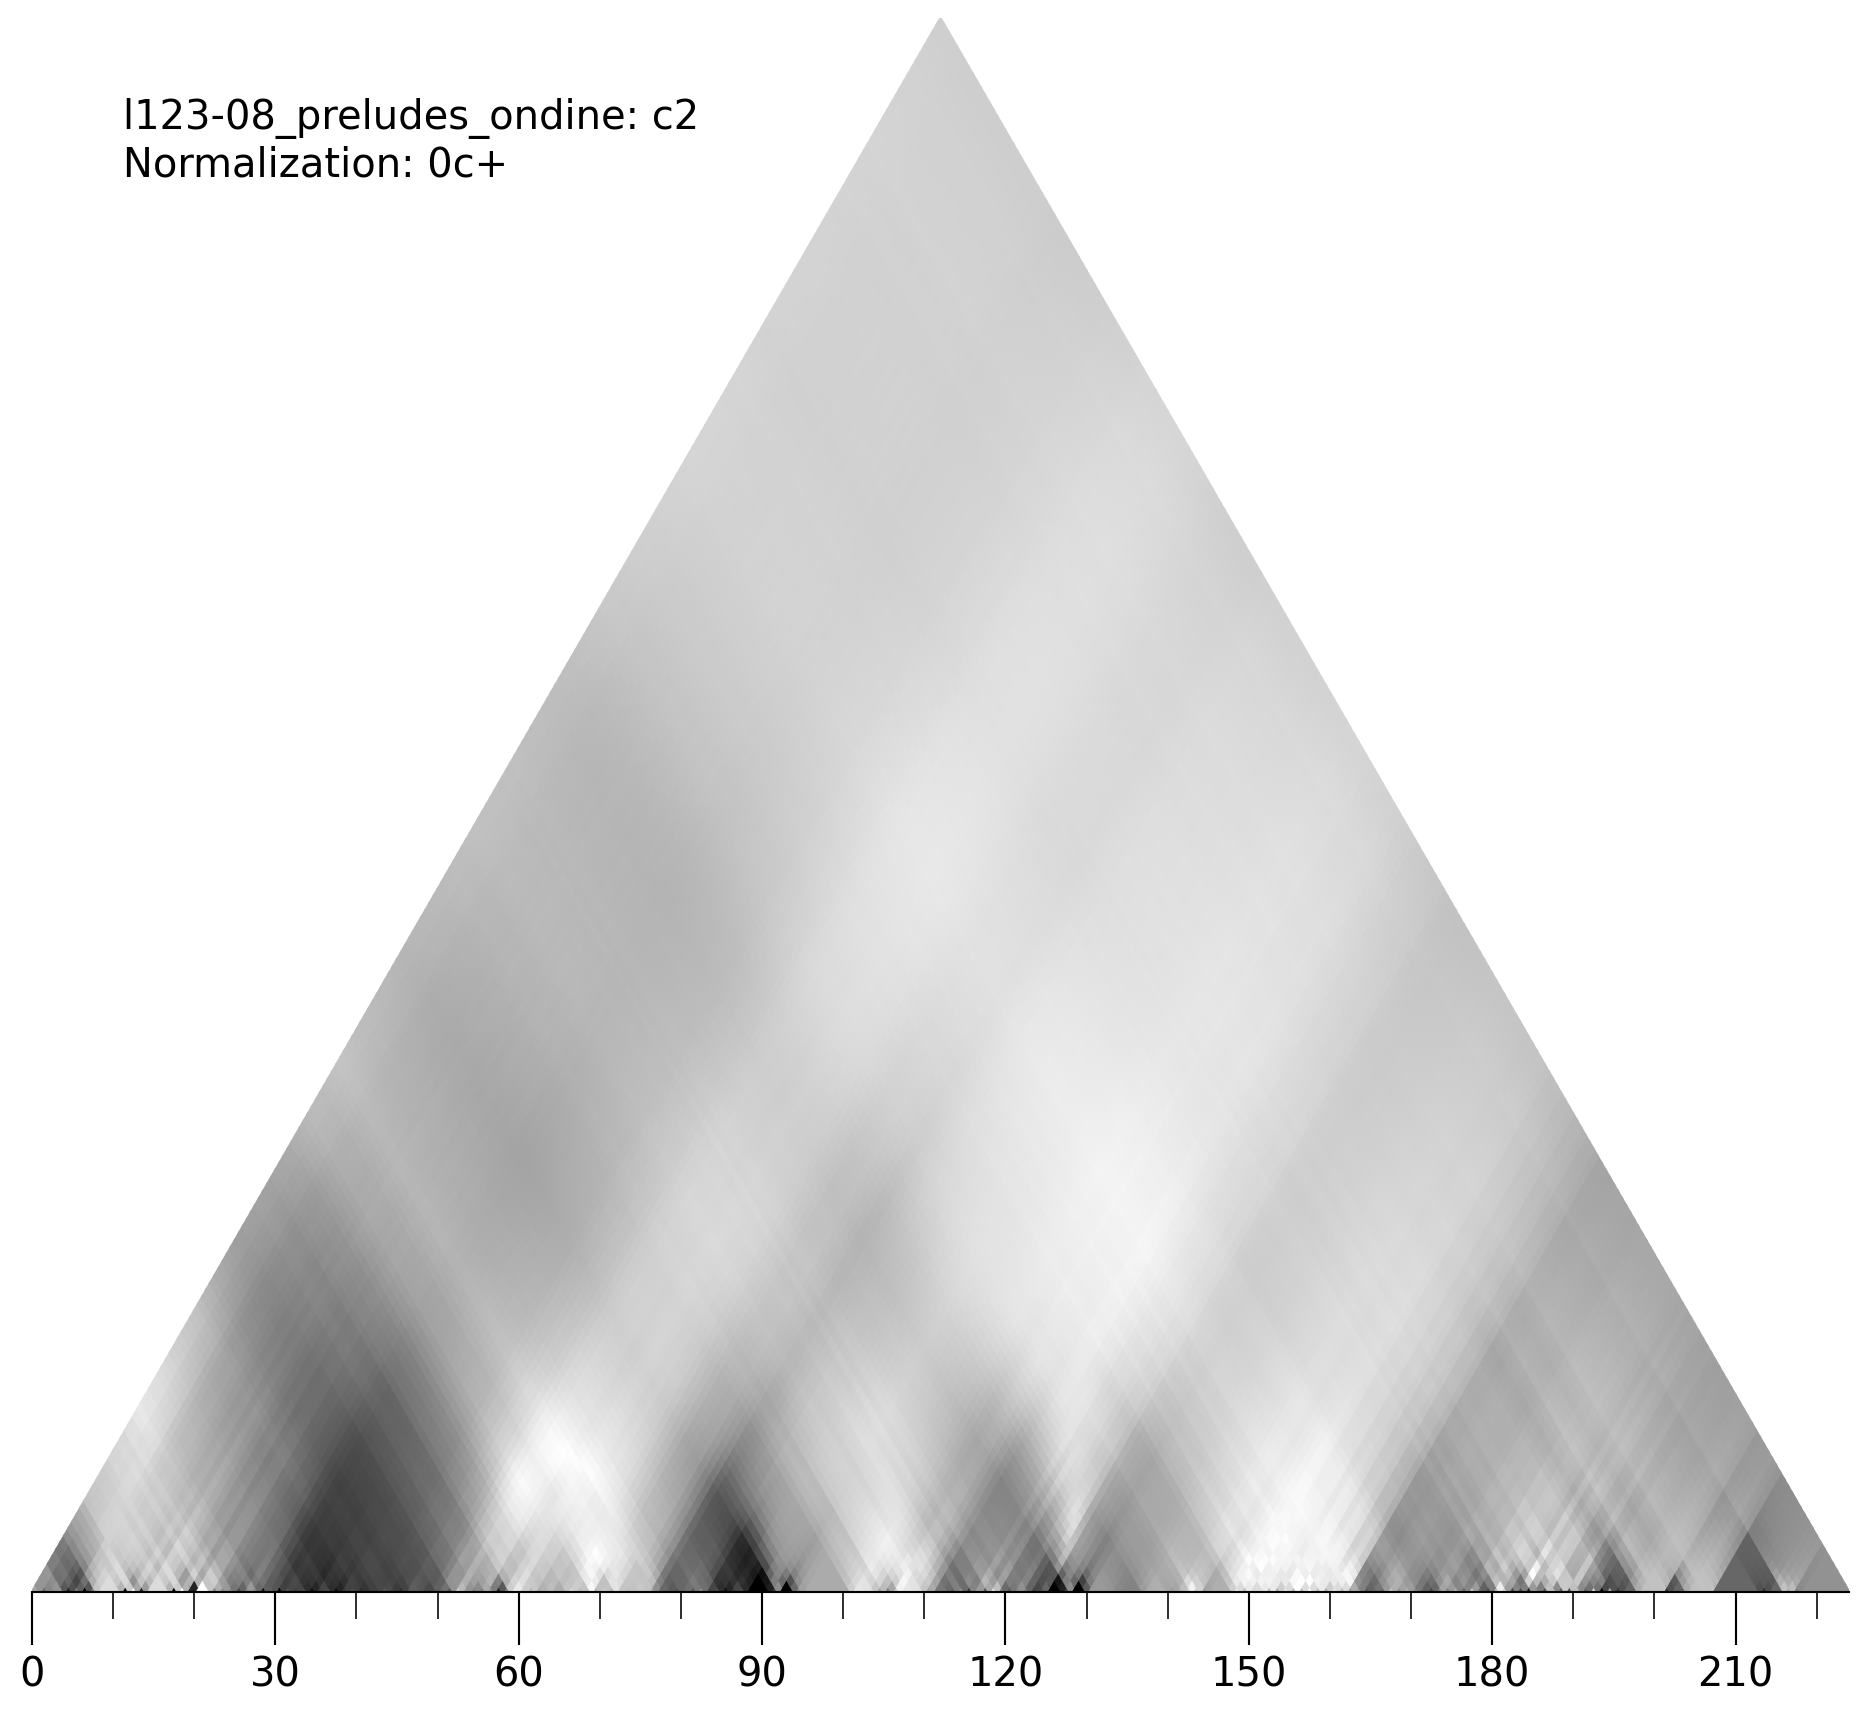

In [7]:
coeff = 2
label = etl.make_wavescape_label(EXAMPLE_FNAME, how, indulge, coeff=coeff)
os.makedirs('figures', exist_ok=True)
path = os.path.join('figures', etl.make_filename(EXAMPLE_FNAME, how, indulge, coeff=coeff, ext='.png'))
wavescapes.single_wavescape_from_pcvs(pcvs[EXAMPLE_FNAME],
                                      width=DEFAULT_FIGURE_SIZE,
                                      coefficient=coeff,
                                      save_label=path,
                                      magn_stra=how,
                                      output_rgba=False,
                                      ignore_phase=True,
                                      aw_per_tick=10,
                                      tick_factor=10,
                                      label=label,
                                      label_size=15)

## Loading Pitch Class Matrices
An `{fname -> np.array}` dictionary where each `(NxNx12)` array contains the aggregated PCVs for all segments that make up a piece. The square matrices contain values only in the upper right triangle, with the lower left beneath the diagonal is filled with zeros. The values are arranged such that row 0 correponds to the original PCV, row 1 the aggregated PCVs for all segments of length = 2 quarter notes, etc. For getting the segment reaching from slice 3 to 5 (including), i.e. length 3, the coordinates are `(2, 5)` (think x = 'length - 1' and y = index of the last slice included).

The following example shows the upper left 3x3 submatrix where
* the first three entries (which are PCVs of size 12) correspond to the pitch class distributions of the piece's first three quarternote slices,
* the two last vectors of the second row each correspond to a sum of two adjacent vectors above, and
* the last entry of the the third row corresponds to the sum all three PCVs.

In [8]:
pcms = etl.get_pcms(DEBUSSY_REPO)
etl.test_dict_keys(pcms, metadata)
print(f"Shape of the PCM for {EXAMPLE_FNAME}: {pcms[EXAMPLE_FNAME].shape}")
pcms[EXAMPLE_FNAME][:3, :3]

Found matrices for all files listed in metadata.tsv.
Shape of the PCM for l123-08_preludes_ondine: (224, 224, 12)


array([[[0. , 1. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0.5, 0.5, 0. ],
        [0. , 2. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 1.5, 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0.5, 0.5, 0. ]],

       [[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 3. , 0. , 0. , 0. , 1. , 0. , 0.5, 0. , 0.5, 0.5, 0. ],
        [0. , 3.5, 0. , 0. , 0. , 1. , 0. , 0.5, 0. , 0.5, 0.5, 0. ]],

       [[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 4.5, 0. , 0. , 0. , 1. , 0. , 1. , 0. , 1. , 1. , 0. ]]])

## Loading Discrete Fourier Transforms
`{fname -> np.array}` containing `(NxNx7)` complex matrices. For instance, here's the first element, a size 7 complex vector with DFT coefficients 0 through 6:

In [9]:
dfts = etl.get_dfts(DEBUSSY_REPO)
etl.test_dict_keys(dfts, metadata)
print(f"Shape of the DFT for {EXAMPLE_FNAME}: {dfts[EXAMPLE_FNAME].shape}")
dfts[EXAMPLE_FNAME][0,0]

Found matrices for all files listed in metadata.tsv.
Shape of the DFT for l123-08_preludes_ondine: (224, 224, 7)


array([ 2.50000000e+00+0.00000000e+00j,  6.83012702e-01+6.83012702e-01j,
       -5.55111512e-17-8.66025404e-01j, -5.00000000e-01-1.00000000e+00j,
       -5.00000000e-01-1.73205081e+00j, -1.83012702e-01-1.83012702e-01j,
       -1.50000000e+00+5.55111512e-17j])

You can view the 7 complex numbers as magnitude-phase pairs. In the following we use magnitude-phase-matrices of this format.

In [10]:
utils.get_coeff(dfts[EXAMPLE_FNAME], 0, 0, deg=True)

array([['2.5+0°'],
       ['0.97+315°'],
       ['0.87+90°'],
       ['1.12+117°'],
       ['1.8+106°'],
       ['0.26+135°'],
       ['1.5+180°']], dtype='<U9')

For convenience, values can also be inspected as strings where the numbers are rounded and angles are shown in degrees:

In [11]:
utils.get_coeff(dfts[EXAMPLE_FNAME], 0, 0, deg=True)

array([['2.5+0°'],
       ['0.97+315°'],
       ['0.87+90°'],
       ['1.12+117°'],
       ['1.8+106°'],
       ['0.26+135°'],
       ['1.5+180°']], dtype='<U9')

## Loading magnitude-phase matrices
`{fname -> np.array}` where each of the `(NxNx6x2)` matrices contains the 6 relevant DFT coefficients converted into magnitude-phase pairs where the magnitudes have undergone at least one normalization, i.e. are all within [0,1]. The first time the notebook runs, the matrices are computed and pickled to disk, from where they can be loaded on later runs.

The parameter `norm_params` can be one or several `(how, indulge)` pairs where `indulge` is a boolean and `how ∈ {'0c', 'post_norm', 'max_weighted', 'max'}`.

### Normalizing magnitudes

The available normalization methods for `how` are:
* **'0c'** default normalisation, will normalise each magnitude by the 0th coefficient (which corresponds to the sum of the weight of each pitch class). This ensures onlypitch class distribution whose periodicity exactly match the coefficient's periodicity can reach the value of 1.
* **'post_norm'** based on the 0c normalisation but "boost" the space of all normalized magnitude so the maximum magnitude observable is set to the max opacity value. This means that if any PCV in the utm given as input reaches the 0c normalized magnitude of 1, this parameter acts like the '0c' one. This magn_strat should be used with audio input mainly, as seldom PCV derived from audio data can reach the maximal value of normalized magnitude for any coefficient.
* **'max'** set the grayscal value 1 to the maximum possible magnitude in the wavescape, and interpolate linearly all other values of magnitude based on that maximum value set to 1. Warning: will bias the visual representation in a way that the top of the visualisation will display much more magnitude than lower levels.
* **'max_weighted'** same principle as max, except the maximum magnitude is now taken at the hierarchical level, in other words, each level will have a different opacity mapping, with the value 1 set to the maximum magnitude t this level. This normalisation is an attempt to remove the bias toward higher hierarchical level that is introduced by the 'max' magnitude process cited previously.

`indulge` is an additional normalization that we apply to the magnitude based on the phase. Since magnitudes of 1 are possible only for a prototypical phase sitting on the unit circle, you can set this parameter to True to normalize the magnitudes by the maximally achievable magnitude given the phase which is bounded by straight lines between adjacent prototypes. (Musical prototypes are visualized in the [midiVERTO webApp](https://dcmlab.github.io/midiVERTO/#/analysis)) The pitch class vectors that benefit most from this normalization in terms of magnitude gain are those whose phase is exactly between two prototypes, such as the "octatonic" combination O₀,₁. The maximal "boosting" factors for the first 5 coefficients are `{1: 1.035276, 2: 1.15470, 3: 1.30656, 4: 2.0, 5: 1.035276}`. The sixth coefficient's phase can only be 0 or pi so it remains unchanged. Use this option if you want to compensate for the smaller magnitude space of the middle coefficients.

In [12]:
mag_phase_path = os.path.join(DATA_FOLDER, 'pickled_magnitude_phase_matrices') 
os.makedirs(mag_phase_path, exist_ok=True)
mag_phase_mx_dict = etl.get_magnitude_phase_matrices(dfts=dfts, data_folder=mag_phase_path, norm_params=norm_method)
etl.test_dict_keys(mag_phase_mx_dict, metadata)
print(f"Shape of the magnitude-phase matrix for {EXAMPLE_FNAME}: {mag_phase_mx_dict[EXAMPLE_FNAME].shape}")

Checking for existing files to be skipped... DONE
No new magnitude-phase matrices to be computed.
Found matrices for all files listed in metadata.tsv.
Shape of the magnitude-phase matrix for l123-08_preludes_ondine: (224, 224, 6, 2)


## Summary wavescapes

This cell depends on the previously loaded magnitude-phase matrices, i.e. a conscious choice of a normalization method has been made above.

`get_most_resonant` returns three `{fname -> nd.array}` dictionaries where for each piece, the three `(NxN)` matrices correspond to

1. the index between 0 and 5 of the most resonant of the six DFT coefficient 1 through 6
2. its magnitude
3. the inverse entropy of the 6 magnitudes

The following example shows these 3 values for the bottom row of the example summary wavescape.

In [13]:
max_coeffs, max_mags, inv_entropies = etl.get_most_resonant(mag_phase_mx_dict)
np.column_stack((max_coeffs[EXAMPLE_FNAME][:3],
max_mags[EXAMPLE_FNAME][:3],
inv_entropies[EXAMPLE_FNAME][:3]))

array([[3.        , 2.        , 3.        , ..., 0.22767643, 0.22767643,
        0.22767643],
       [0.        , 2.        , 2.        , ..., 0.22767643, 0.22767643,
        0.22767643],
       [0.        , 0.        , 2.        , ..., 0.22767643, 0.22767643,
        0.22767643]])

In order to plot these values in a wavescape, they need to be transformed into color values. The function `most_resonant2color()` attributes six equidistant hues to the most resonant coefficients and takes one of the other two matrices to adapt the opacity.

In the first example the opacity shows the magnitude of the most resonant coefficient:

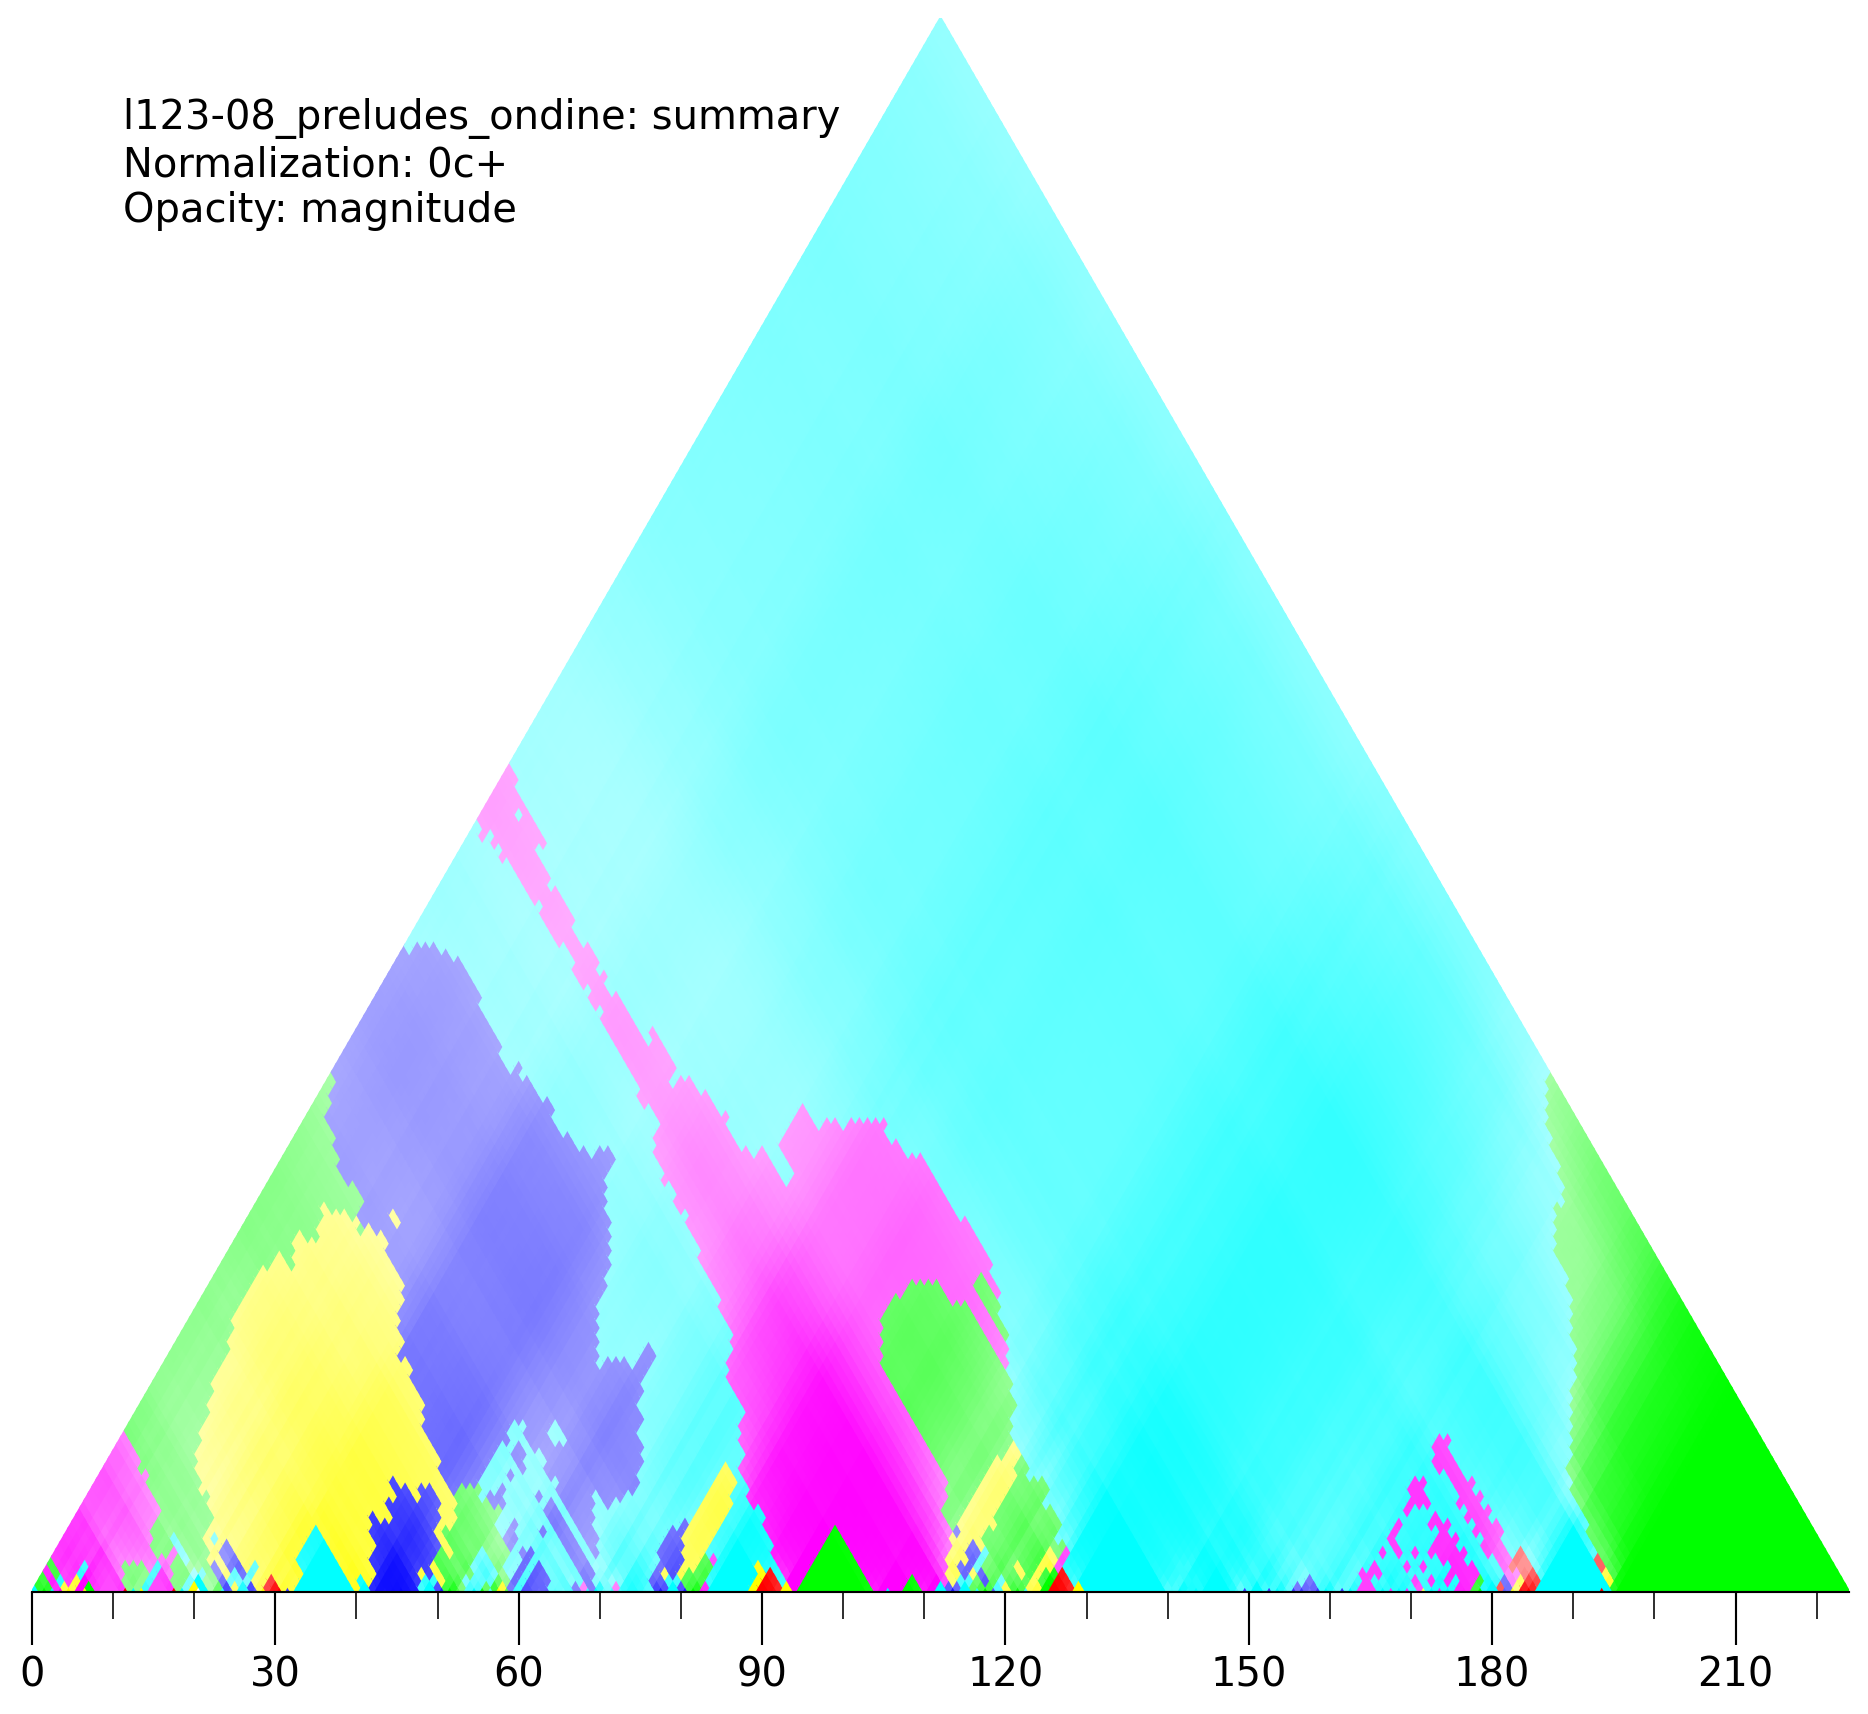

In [14]:
colors = utils.most_resonant2color(max_coeffs[EXAMPLE_FNAME], max_mags[EXAMPLE_FNAME])
by_entropy = False
label = etl.make_wavescape_label(EXAMPLE_FNAME, how, indulge, by_entropy=by_entropy)
ws = wavescapes.Wavescape(colors, width=DEFAULT_FIGURE_SIZE)
ws.draw(aw_per_tick=10, tick_factor=10, label=label, label_size=15)#, subparts_highlighted=[110,134])
path = os.path.join('figures', etl.make_filename(EXAMPLE_FNAME, how, indulge, summary_by_entropy=by_entropy, ext='.png'))
plt.savefig(path)

In the second example, the opacity corresponds to the inverse normalized entropy of the 6 magnitudes. In other words, opacity is maximal if the most resonant coefficient is the only one with magnitude > 0; whereas the color is white when all coefficients have the same magnitude.

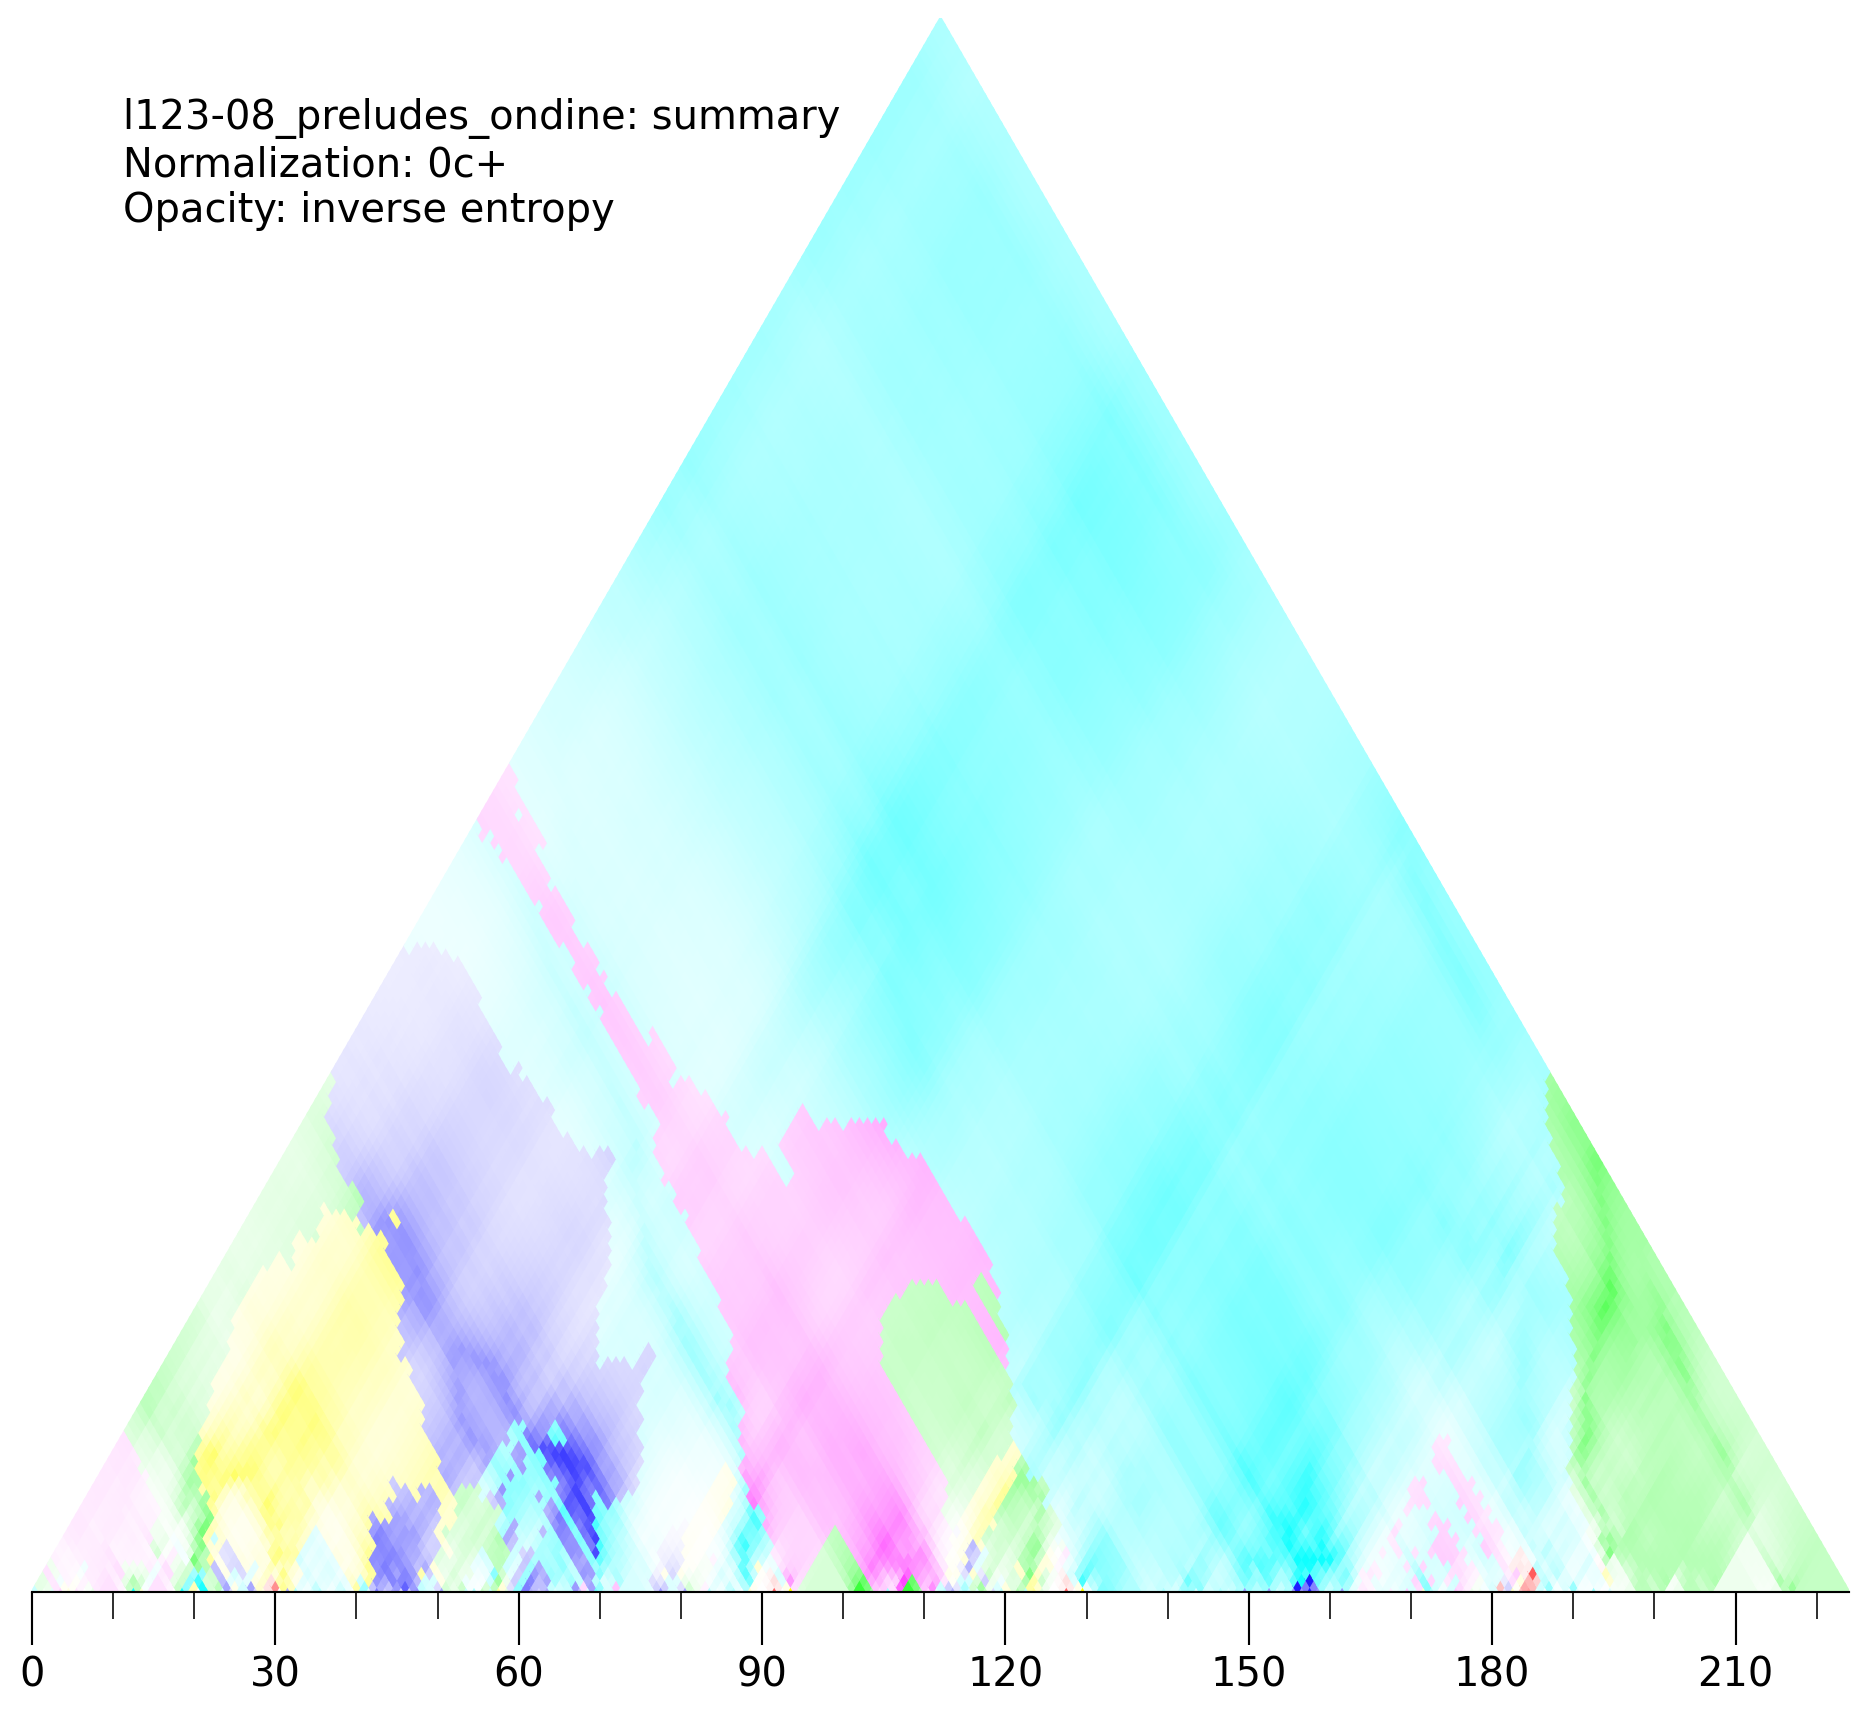

In [15]:
colors = utils.most_resonant2color(max_coeffs[EXAMPLE_FNAME], inv_entropies[EXAMPLE_FNAME])
by_entropy = True
label = etl.make_wavescape_label(EXAMPLE_FNAME, how, indulge, by_entropy=by_entropy)
ws = wavescapes.Wavescape(colors, width=DEFAULT_FIGURE_SIZE)
ws.draw(aw_per_tick=10, tick_factor=10, label=label, label_size=15) #, subparts_highlighted=[110,134]
path = os.path.join('figures', etl.make_filename(EXAMPLE_FNAME, how, indulge, summary_by_entropy=by_entropy, ext='.png'))
plt.savefig(path)

# Metrics

In this section, we compile a `pd.DataFrame` containing the results of all the metrics used in the paper. We store both an original version of the metrics where each piece corresponds to a row and the columns the metric results across the coefficients, and a melted version where each tuple (piece, coefficient) is a row and there is one column per metric. Note that the second version only applies to metrics that have one value per coefficient (thus not the inverse coherence and piece fragmentation). The metrics are stored and used for testing in `results/`. Optional plots and tests can be done by adjusting the parameters of the wrapper function `get_metric` that can be found in `etl.py`. 


`get_metric`: `mname, pd.DataFrame -> pd.DataFrame` takes the name of the metric to be computed and the dataframe to add the metrics to and returns the updated dataframe. Optionally, it takes the needed `np.array`s to compute each metric, the column names, and specifics for the creation of additional plots and tests. For more details, refer to the documentation of the function.

In [16]:
# let's start from the available metadata for each piece
metadata_metrics = metadata.copy()

## Coefficients’ prevalence

The **prevalence of each coefficient** can be computed using the `mname` 'percentage_resonance' and providing the `max_coeffs` matrix. 

In fact, the prevalence of coefficient $n$ in a piece: $W(n)=1/N \sum_{i \in S(n)} i$ where $N$ is the total number of entries in the matrix, $S(n)$ is the set of the indices of the entries in the summary wavescapes that are attributed to coefficient $n$ (i.e., where coefficient $n$ is the most prominent among the six).

Found matrices for all files listed in metadata.tsv.
The example center of mass list has len 6.
Example results [0.99692521 0.00203333 0.15572307 0.32240627 0.51894465 0.00396747]


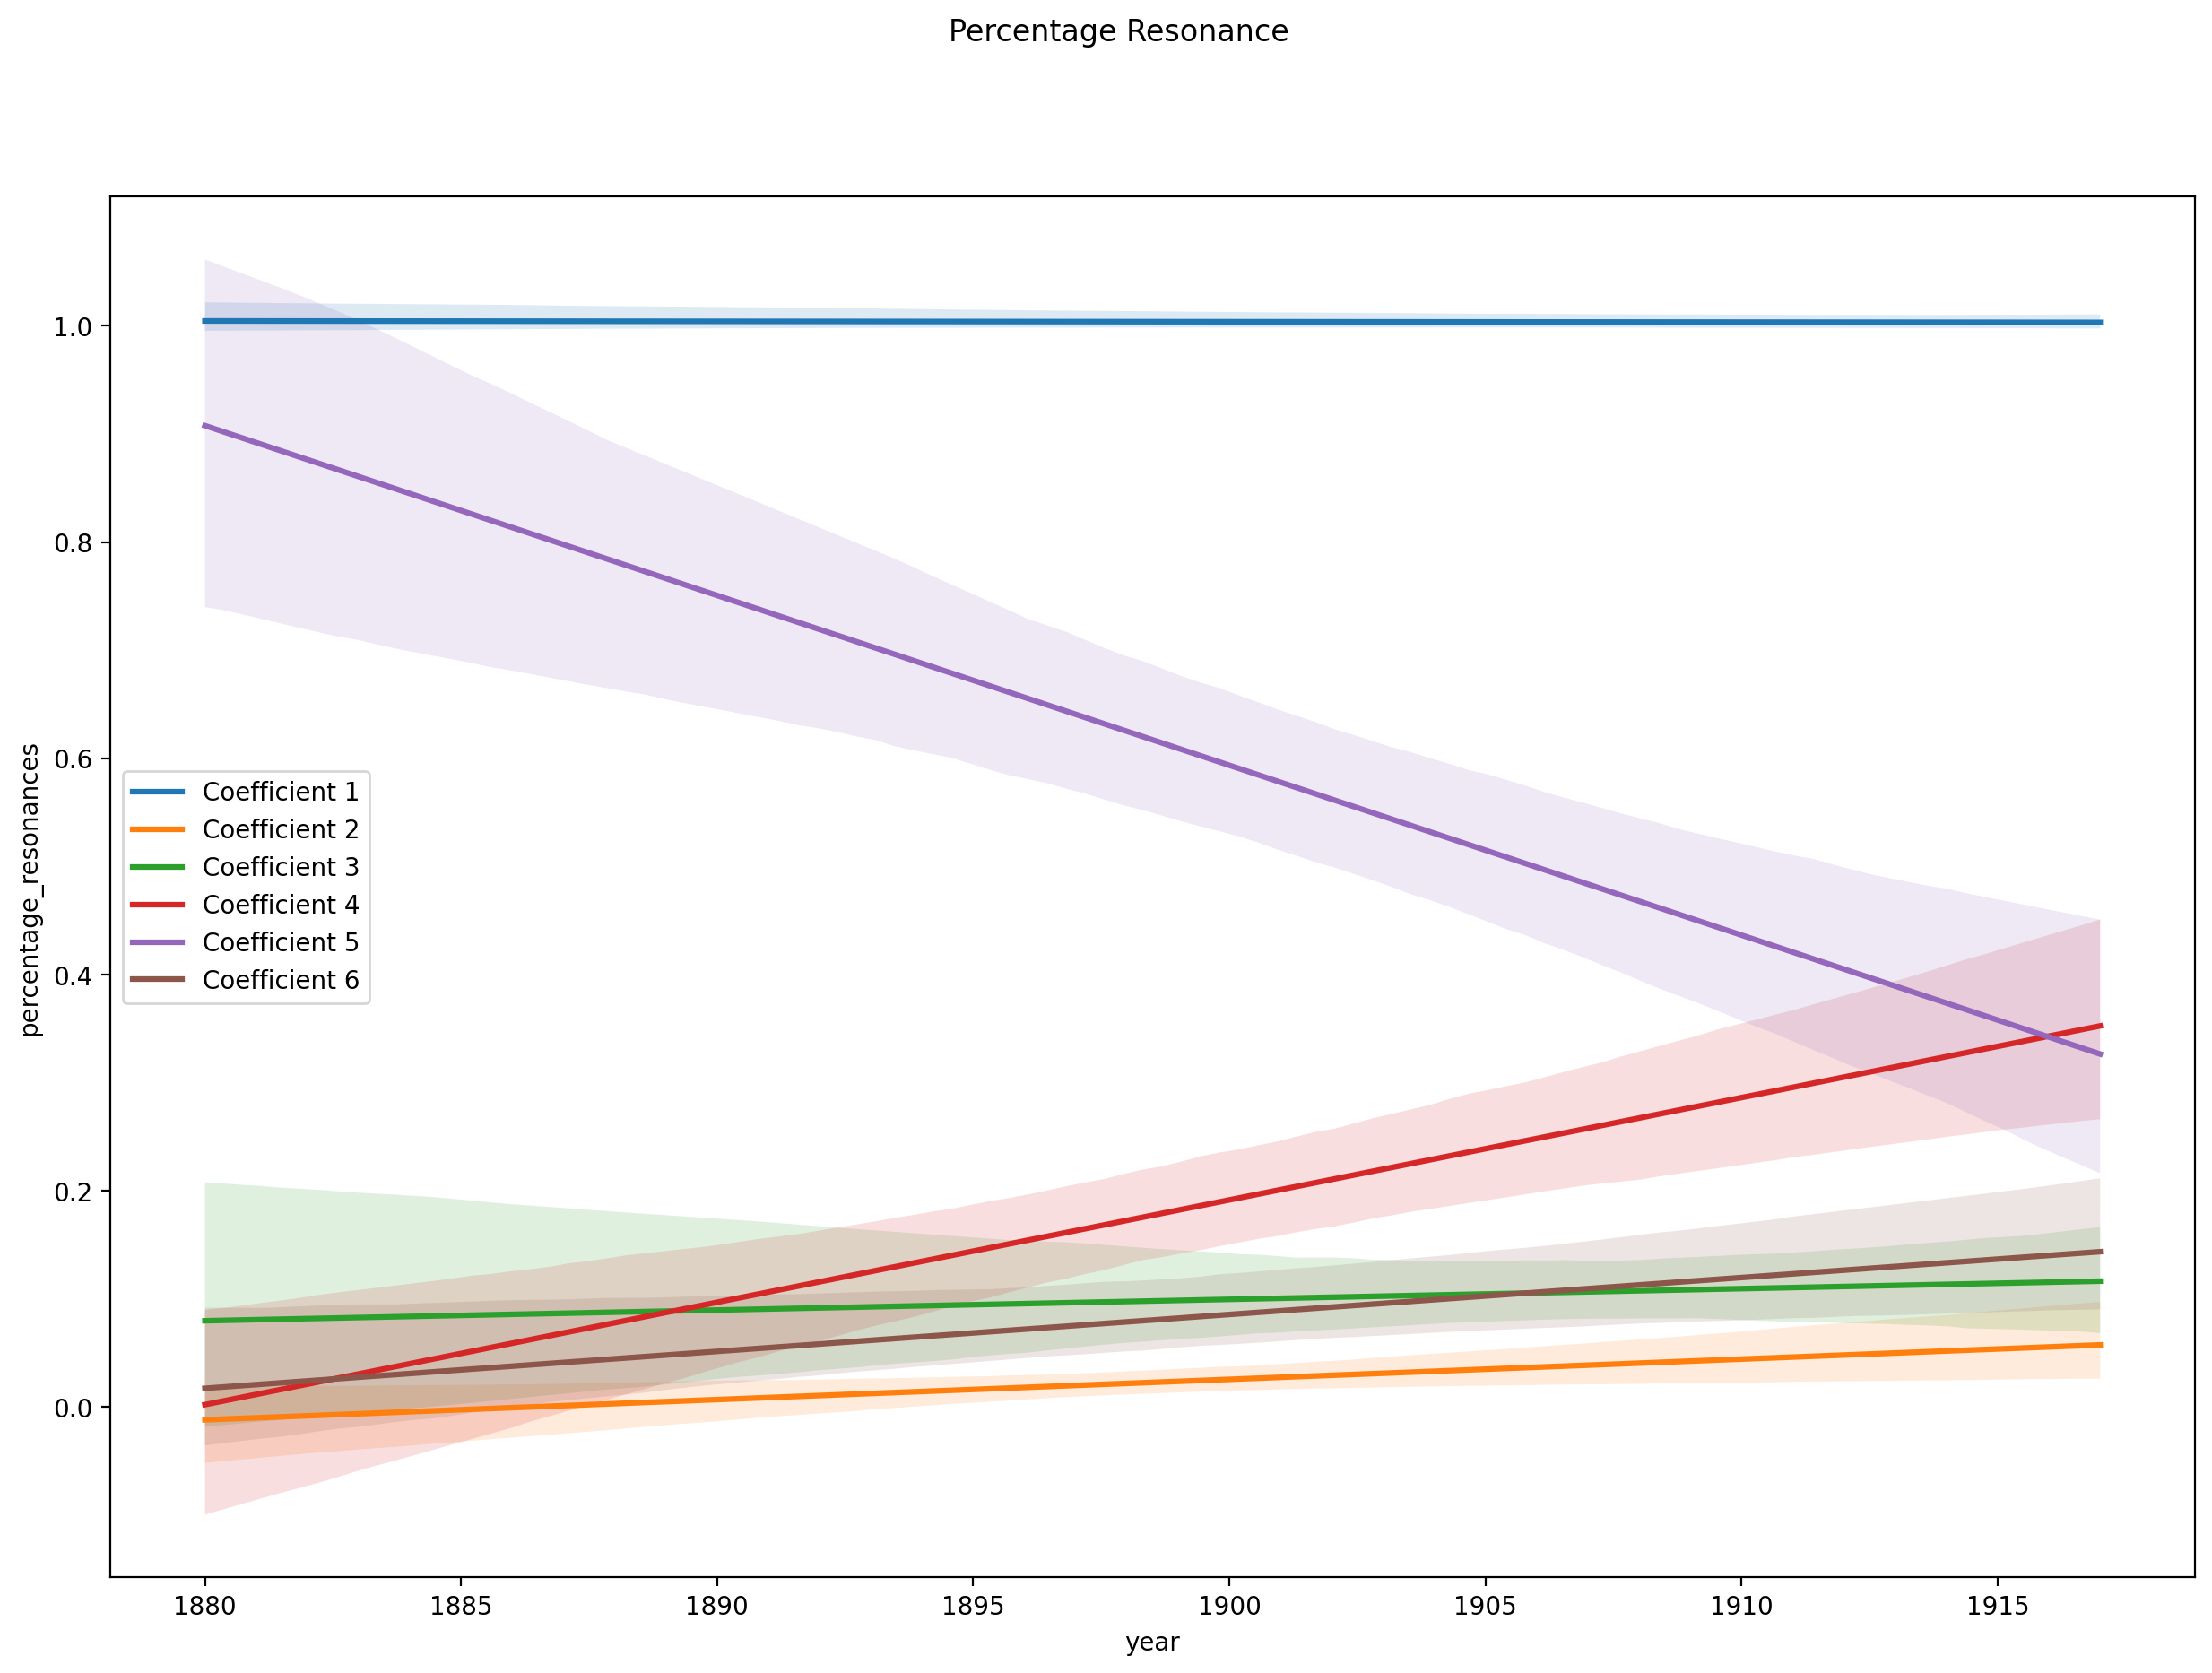

In [17]:
# defining column names
cols = [f"percentage_resonances_{i}" for i in range(1,7)]

metadata_metrics = etl.get_metric('percentage_resonance', metadata_metrics, 
                              max_coeffs=max_coeffs, cols=cols, 
                              store_matrix=True, show_plot=True, unified=True,
                              save_name='percentage_resonance', title='Percentage Resonance')

In [18]:
metadata_metrics[cols].head()

,percentage_resonances_1,percentage_resonances_2,percentage_resonances_3,percentage_resonances_4,percentage_resonances_5,percentage_resonances_6
fname,,,,,,
l000_etude,0.996925,0.002033,0.155723,0.322406,0.518945,0.003967
l000_soirs,0.988764,0.007322,0.251988,0.181795,0.530236,0.039894
l009_danse,0.994774,0.001553,0.073636,0.053689,0.875452,0.000896
l066-01_arabesques_premiere,0.997669,0.000391,0.085431,0.024345,0.889906,0.002258
l066-02_arabesques_deuxieme,0.999649,0.000482,0.050019,0.039315,0.813242,0.097293


### Entropy-weighted coefficients’ prevalence (default)

In order to account for the certainty that a certain coefficient is actually the most resonance, we weigh the previous metric by entropy as follows: $W(n)=1/N \sum_{i \in S(n)} w_i$ where $N$ is the total number of entries in the wavescape, $S(n)$ is the set of the indices of the entries in the summary wavescapes that are attributed to coefficient $n$ (i.e., where coefficient $n$ is the most prominent among the six), and $w_i$ is the weight (opacity) of the $i$-th node in the summary wavescape, in this case, the entropy of $i$.

The **entropy weighted prevalence of each coefficient** can be computed using the `mname` 'percentage_resonance_entropy' and providing the `max_coeffs` matrix and the  `inv_entropies` matrix. 


Found matrices for all files listed in metadata.tsv.
The example center of mass list has len 6.
Example results [3.67541420e-05 3.37187982e-04 3.62322712e-02 7.44989149e-02
 1.13180661e-01 5.87240293e-04]


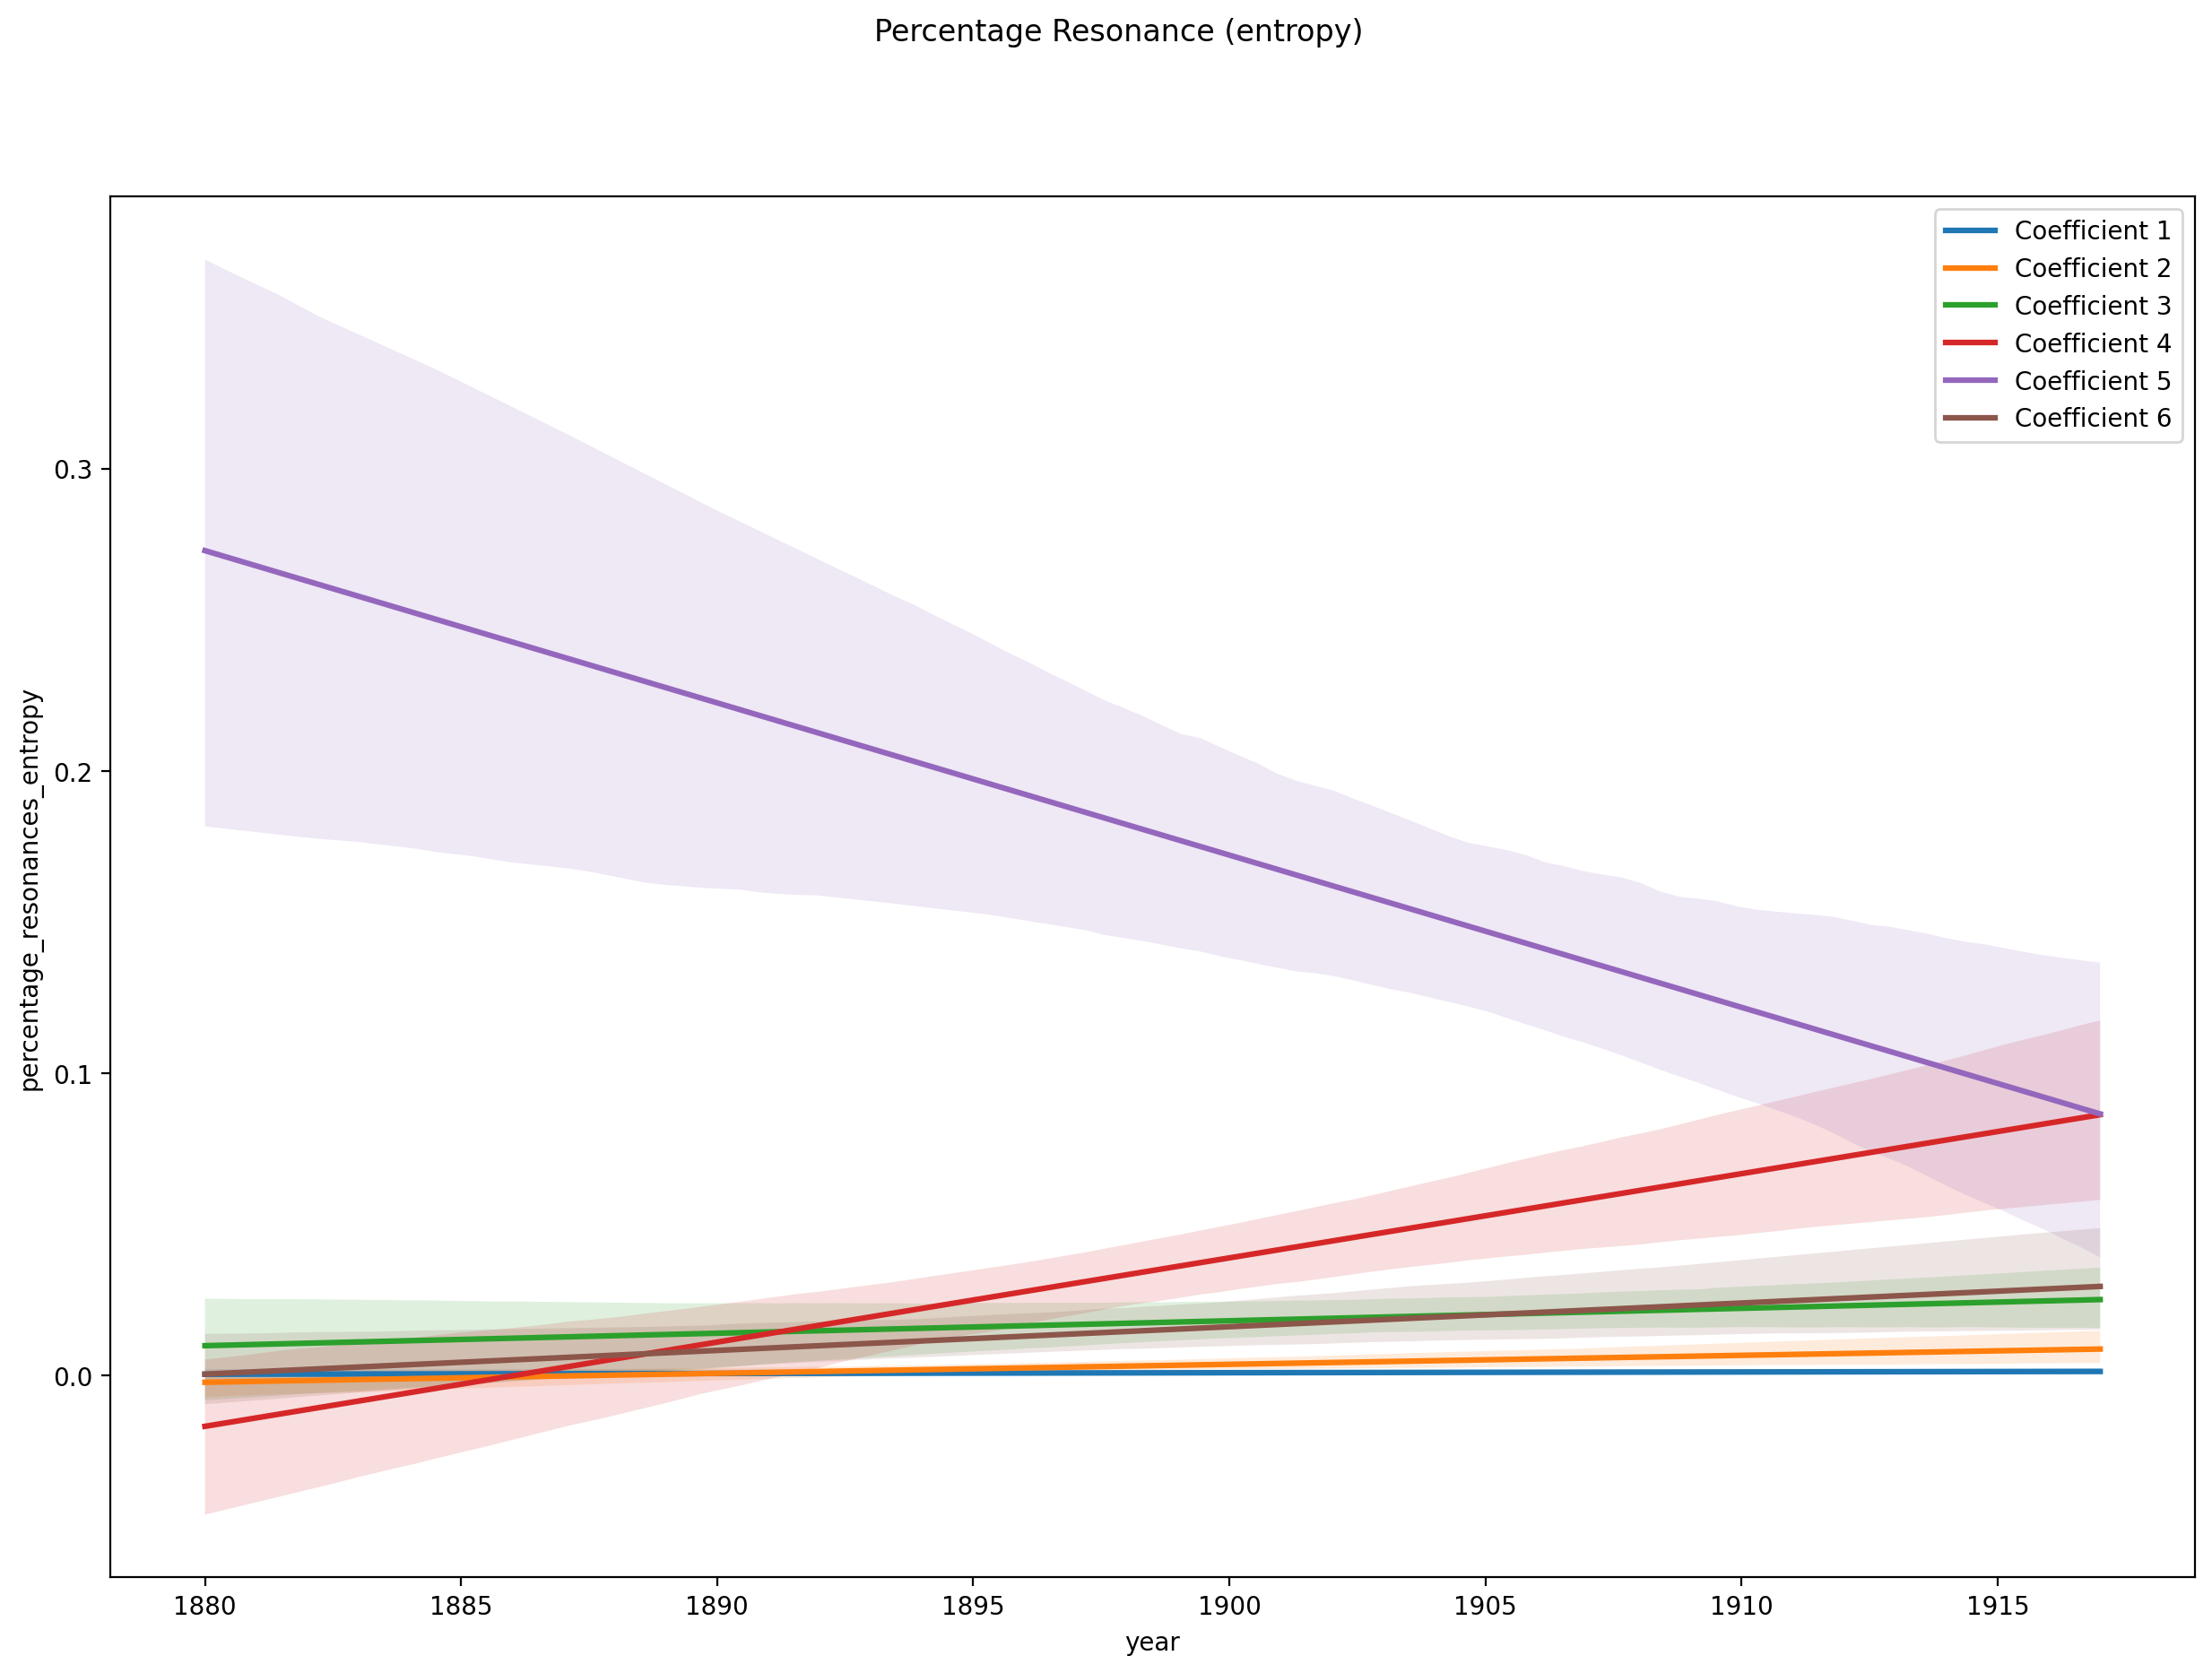

In [19]:
cols = [f"percentage_resonances_entropy_{i}" for i in range(1,7)]

metadata_metrics = etl.get_metric('percentage_resonance_entropy', metadata_metrics, 
                              cols=cols,
                              max_coeffs=max_coeffs, inv_entropies=inv_entropies,
                              store_matrix=True, show_plot=True, unified=True,
                              save_name='percentage_resonance_entropy', title='Percentage Resonance (entropy)')

In [20]:
metadata_metrics[cols].head()

,percentage_resonances_entropy_1,percentage_resonances_entropy_2,percentage_resonances_entropy_3,percentage_resonances_entropy_4,percentage_resonances_entropy_5,percentage_resonances_entropy_6
fname,,,,,,
l000_etude,3.675414e-05,0.000337,0.036232,0.074499,0.113181,0.000587
l000_soirs,0.000000e+00,0.002272,0.061014,0.042162,0.096473,0.009157
l009_danse,8.239907e-06,0.000328,0.019104,0.011472,0.305091,0.000145
l066-01_arabesques_premiere,8.072669e-21,0.000043,0.031662,0.005054,0.433356,0.000263
l066-02_arabesques_deuxieme,1.658894e-04,0.000058,0.009398,0.008821,0.226211,0.010527


## Post-hoc analysis of hierarchical prevalence
### Moment of Inertia

Moment of inertia of coefficient $n$ in the summary wavescape: $I(n)=1/N \sum_{i \in S(n)} w_i y_i^2$, where N is the total number of entries in the wavescape, $S(n)$ is the set of the indices of the entries in the summary wavescapes that are attributed to coefficient $n$ (i.e., where coefficient n is the most prominent among the six), $w_i$ is the magnitude of the $i$-th entry in the summary wavescape, and $y_i$ is the vertical coordinate of the $i$-th entry in the summary wavescape.

The **moment of inertia** can be computed using the `mname` 'moment_of_inertia' and providing the `max_coeffs` matrix and the `max_mags` matrix. 



Found matrices for all files listed in metadata.tsv.
The example center of mass list has len 6.
Example results [1.90162563e-08 3.43506222e-06 4.49260306e-03 6.56131010e-03
 3.25955897e-02 2.60217825e-05]


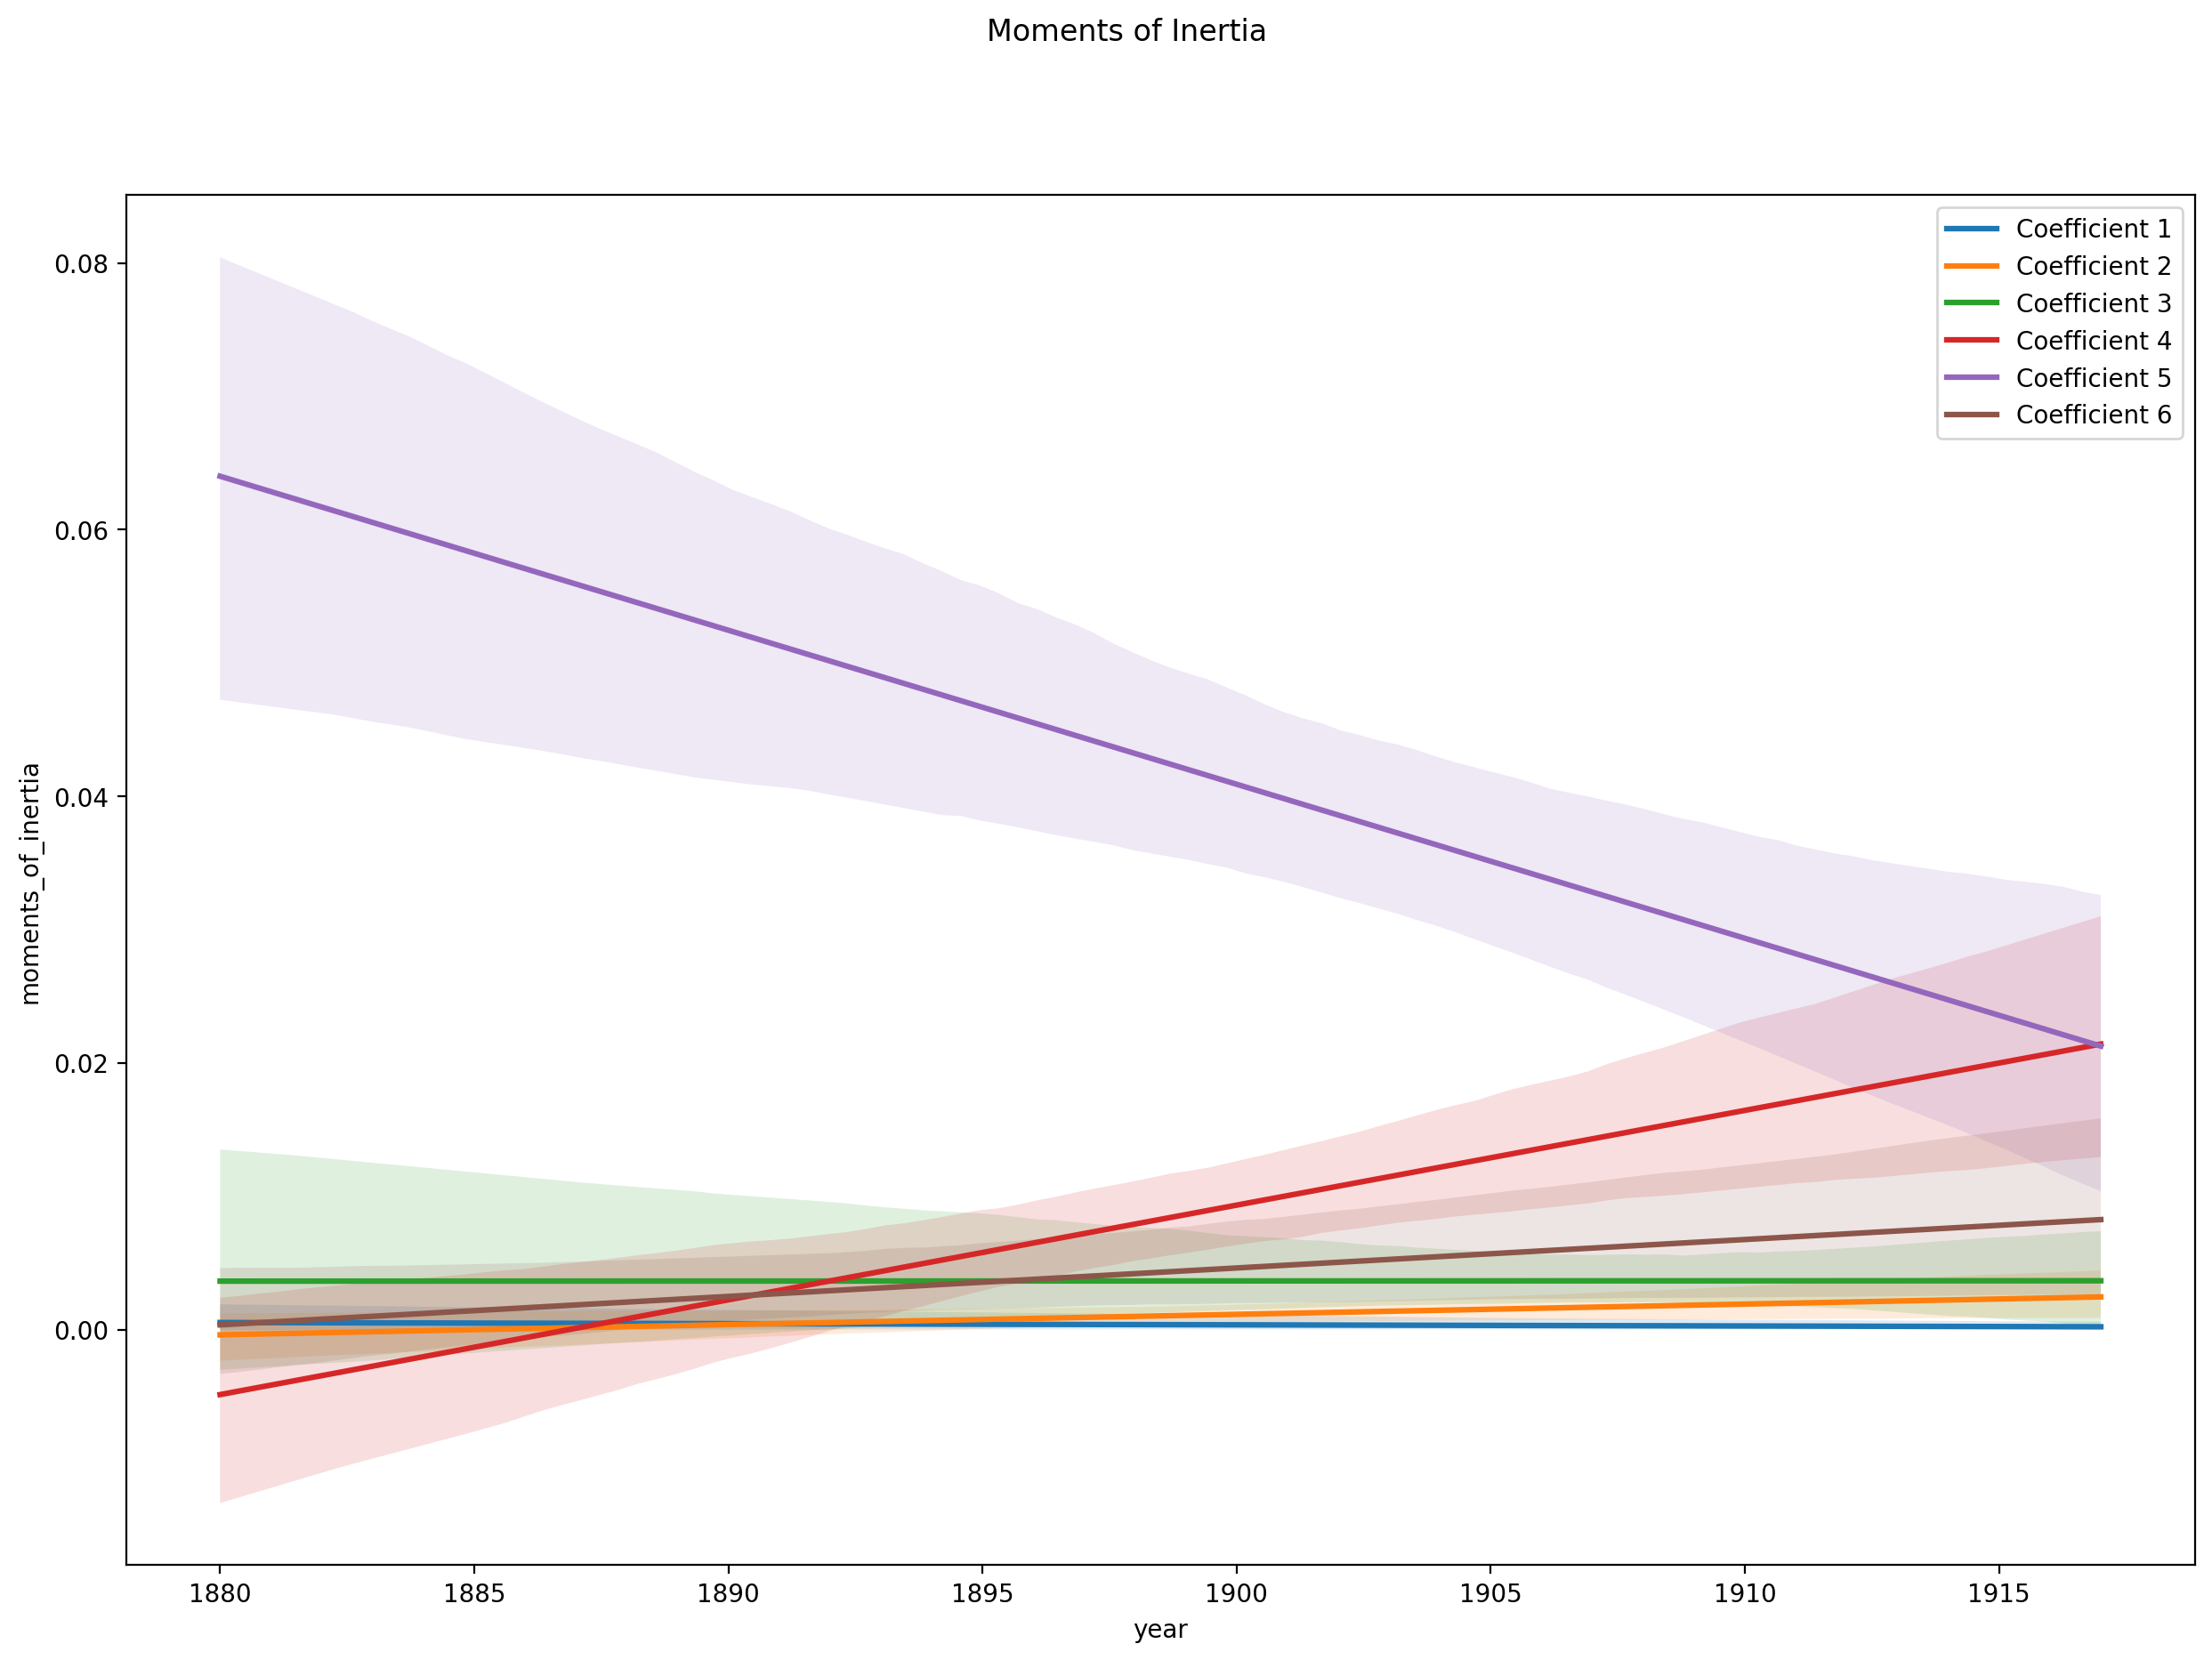

In [21]:
cols = [f"moments_of_inertia_{i}" for i in range(1,7)]

metadata_metrics = etl.get_metric('moment_of_inertia', metadata_metrics, 
                              cols=cols,
                              max_coeffs=max_coeffs, max_mags=max_mags,
                              store_matrix=True, show_plot=True, unified=True,
                              save_name='moments_of_inertia', title='Moments of Inertia')

In [22]:
metadata_metrics[cols].head()

,moments_of_inertia_1,moments_of_inertia_2,moments_of_inertia_3,moments_of_inertia_4,moments_of_inertia_5,moments_of_inertia_6
fname,,,,,,
l000_etude,1.901626e-08,3.435062e-06,0.004493,0.006561,0.032596,2.602178e-05
l000_soirs,0.000000e+00,7.947714e-06,0.005599,0.004763,0.050803,3.825239e-04
l009_danse,0.000000e+00,8.055411e-07,0.000779,0.000159,0.069761,5.825153e-08
l066-01_arabesques_premiere,6.246957e-10,3.819923e-09,0.001683,0.000014,0.071808,2.936798e-07
l066-02_arabesques_deuxieme,1.248622e-06,4.572613e-08,0.000445,0.000038,0.058325,1.940579e-03


## Measure Theoretic Entropy

Measure-theoretic entropy: Let $A={A_1,...,A_k}$ be a (finite) partition of a probability space $(X,P(X),)$: the entropy of the partition $A$ is defined as $H(A)= - \sum_{i} \mu(A_i) \log \mu(A_i)$. We can take $X$ as the support of the wavescape, $A$ as the set of the connected regions in the unified wavescape, and $\mu(Y)=(area-of-Y)/(area-of-X)$ for any subset $Y$ of the wavescape.

The **measure theoretic entropy** can be computed using the `mname` 'partition_entropy' and providing the `max_coeffs` matrix. Note that the measure theoretic entropy is defined as a global metric over the piece. 


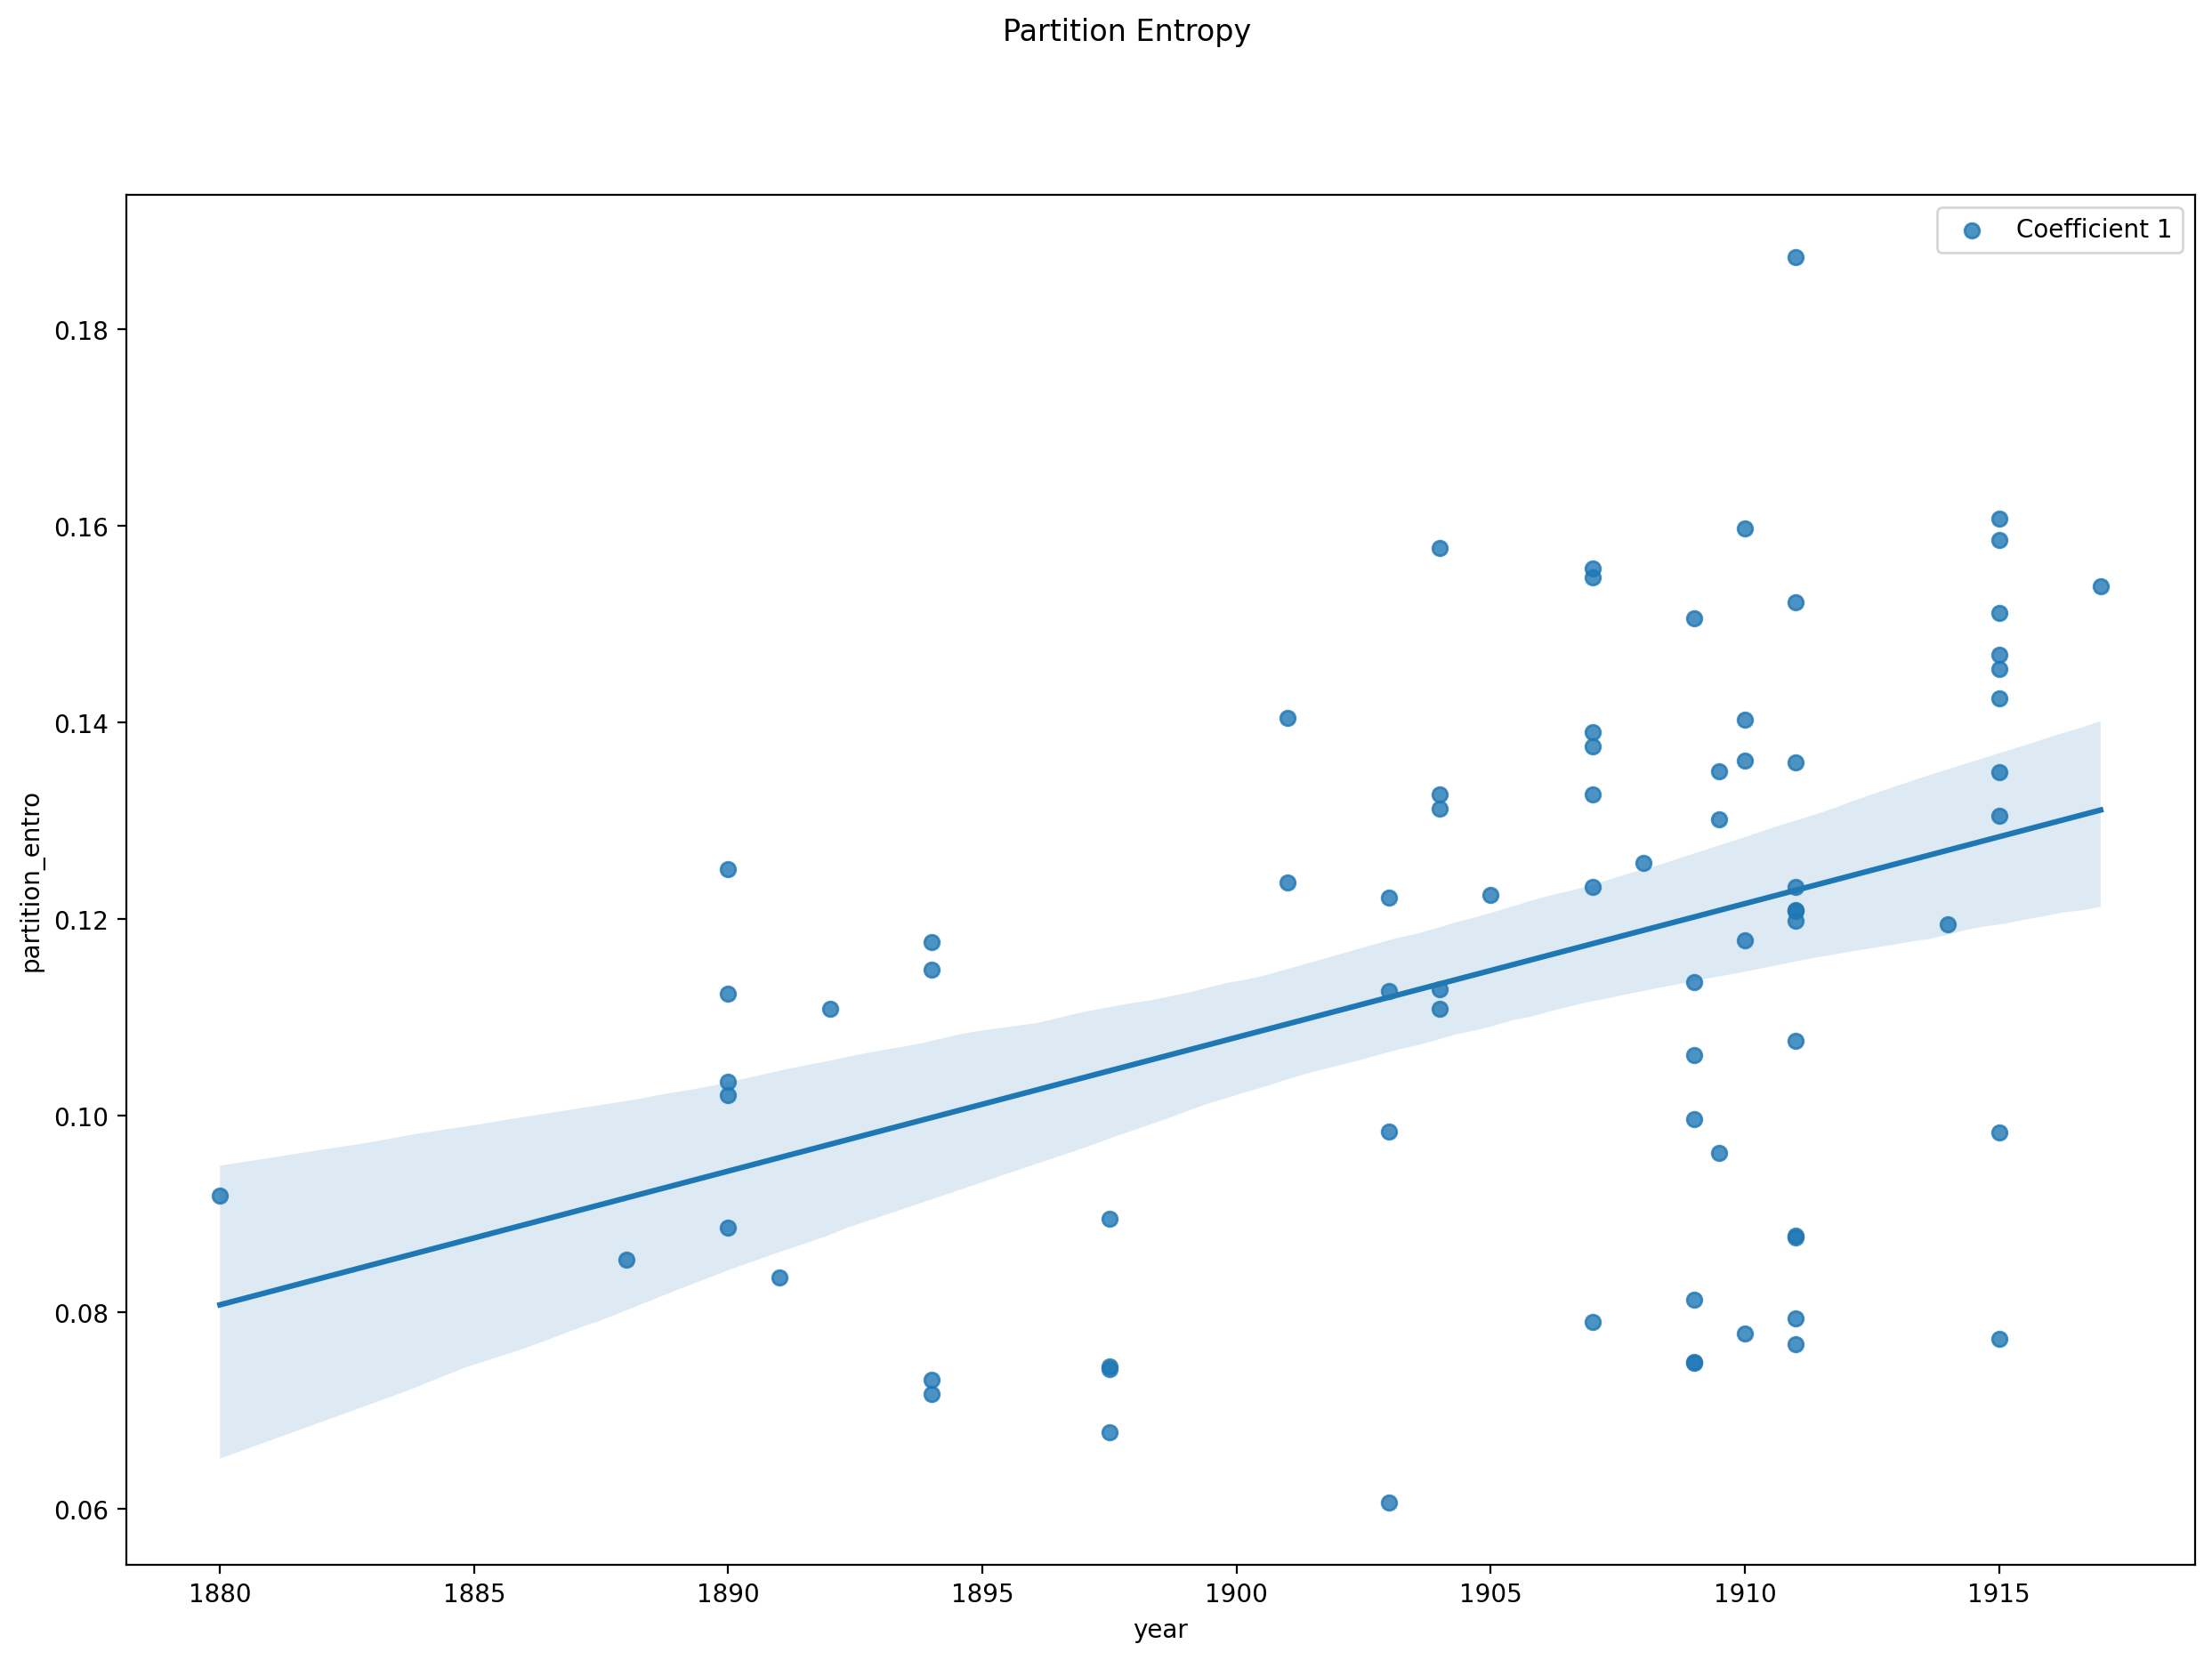

In [23]:
cols = 'partition_entropy'

metadata_metrics = etl.get_metric('partition_entropy', metadata_metrics, 
                              cols=cols,
                              max_coeffs=max_coeffs,
                              store_matrix=True, scatter=True, show_plot=True, unified=True, 
                              save_name='partition_entropy', title='Partition Entropy')

In [24]:
metadata_metrics[cols].head()

fname
l000_etude                     0.130532
l000_soirs                     0.153896
l009_danse                     0.091874
l066-01_arabesques_premiere    0.085412
l066-02_arabesques_deuxieme    0.083545
Name: partition_entropy, dtype: float64

## Global prototypicality

The global prototypicality is the slope $P$ of the regression line $V_l ~ P(l/L)+c$, where $c$ is an intercept term. $V_l = \frac{\sum_o M_{o,l}}{n - l}$ is the average maximal magnitude for each hierarchical level as, where $n - l$ is the number of nodes at each hierarchical level and $l$ as the hierarchical level of the summary wavescape.

The **global prototypicality** can be computed using the `mname` 'inverse_coherence' and providing the `max_mags` matrix. Note that the measure global prototypicality also is defined as a global metric over the piece. 


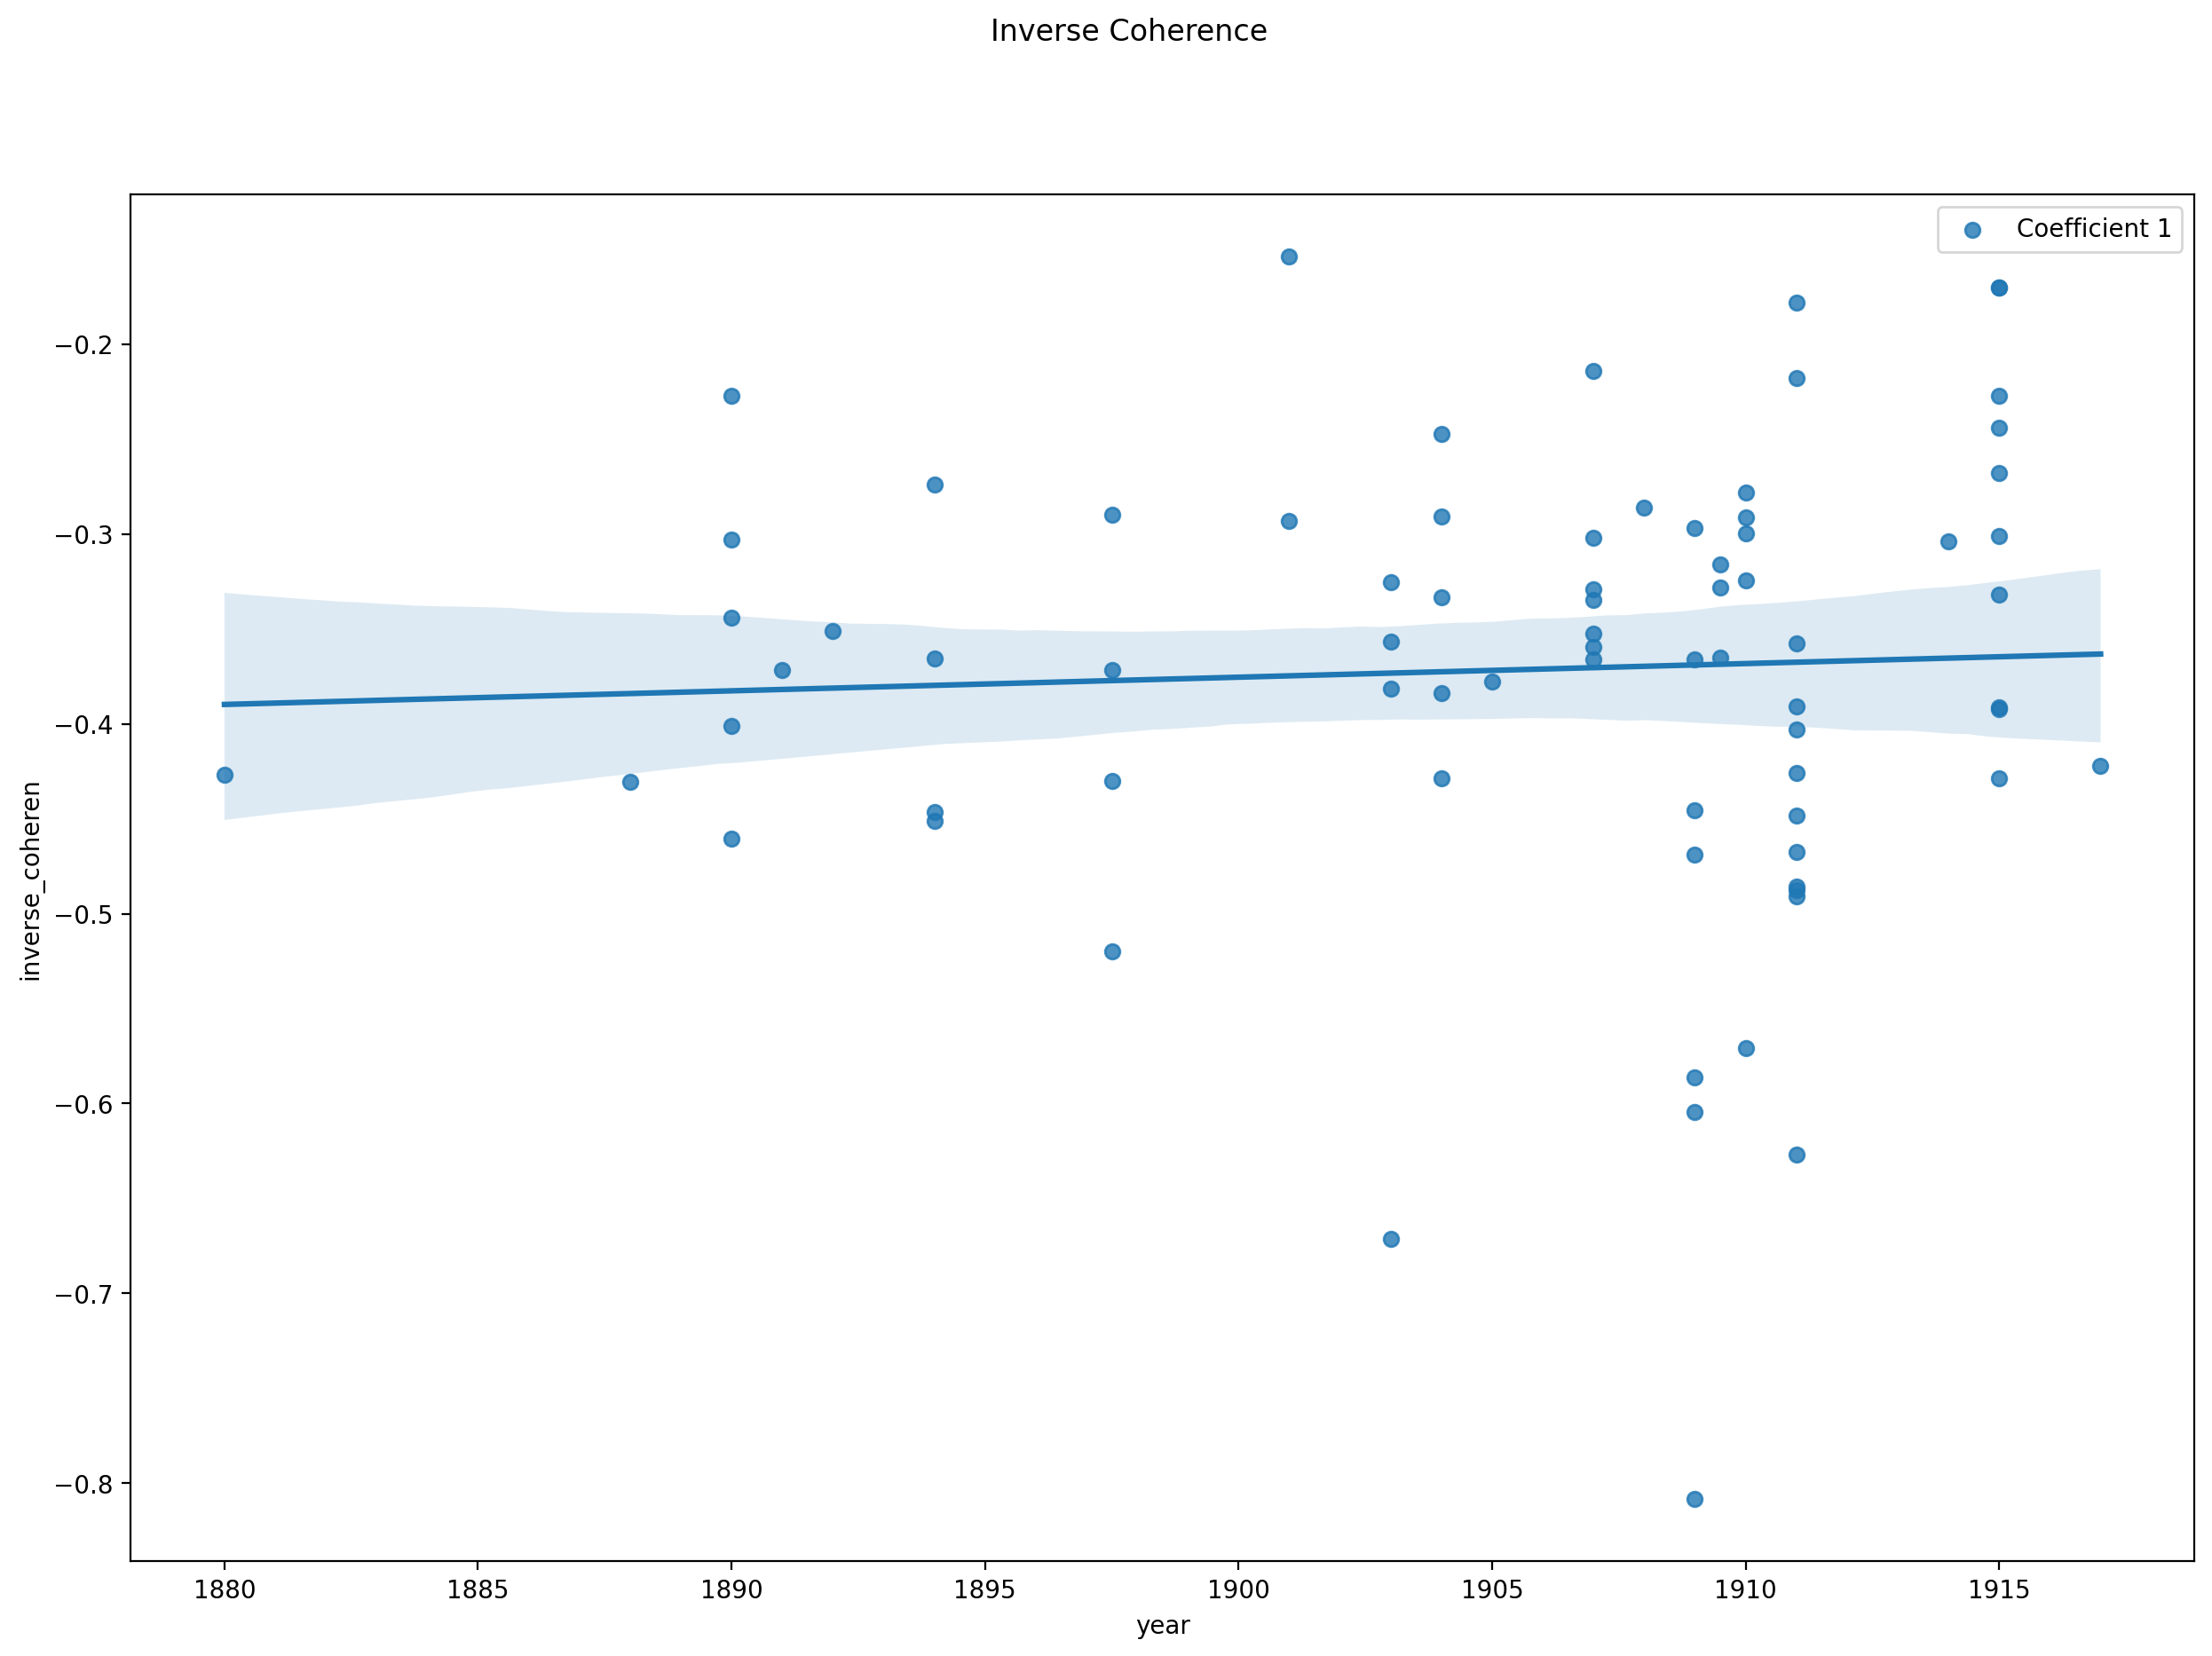

In [25]:
cols = 'inverse_coherence'
metadata_metrics = etl.get_metric('inverse_coherence', metadata_metrics, 
                              cols=cols,
                              max_mags=max_mags,
                              store_matrix=True, show_plot=True, unified=True, scatter=True,
                              save_name='inverse_coherence', title='Inverse Coherence')

In [26]:
metadata_metrics[cols].head()

fname
l000_etude                    -0.332186
l000_soirs                    -0.422060
l009_danse                    -0.426779
l066-01_arabesques_premiere   -0.430629
l066-02_arabesques_deuxieme   -0.371912
Name: inverse_coherence, dtype: float64

# Storing the final metrics files

In [31]:
if not os.path.isdir('results'):
    os.makedirs('results')

metadata_metrics.reset_index().to_csv(os.path.join('results','results.csv'), index=False)

In [28]:
metadata_metrics = metadata_metrics.reset_index()

In [29]:
# melting the results to be used for testing on coefficient specific metrics

resonances_cols = [f"percentage_resonances_{i}" for i in range(1,7)]
entropy_cols = [f"percentage_resonances_entropy_{i}" for i in range(1,7)]
moi_cols = [f"moments_of_inertia_{i}" for i in range(1,7)]

metadata_res = pd.melt(metadata_metrics, id_vars=['fname', 'length_qb', 'year', 'last_mc', 'partition_entropy', 'inverse_coherence'], value_vars=resonances_cols, 
                       var_name='variable_resonance', value_name='value_resonance')
metadata_res_ent = pd.melt(metadata_metrics, id_vars=['fname', 'length_qb', 'year', 'last_mc', 'partition_entropy', 'inverse_coherence'], value_vars=entropy_cols, 
                       var_name='variable_resonance_entropy', value_name='value_resonance_entropy')
metadata_moi = pd.melt(metadata_metrics, id_vars=['fname', 'length_qb', 'year', 'last_mc', 'partition_entropy', 'inverse_coherence'], value_vars=moi_cols, 
                       var_name='variable_inertia', value_name='value_inertia')

metadata_melted = metadata_res.merge(metadata_res_ent, on=['fname', 'length_qb', 'year', 'last_mc', 'partition_entropy', 'inverse_coherence']).merge(metadata_moi, on=['fname', 'length_qb', 'year', 'last_mc', 'partition_entropy', 'inverse_coherence'])
metadata_melted.reset_index().to_csv(os.path.join('results','results_melted.csv'), index=False)
metadata_melted.sample(5)

,fname,length_qb,year,last_mc,partition_entropy,inverse_coherence,variable_resonance,value_resonance,variable_resonance_entropy,value_resonance_entropy,variable_inertia,value_inertia
14137,l123-11_preludes_tierces,330.0,1911.0,165,0.123335,-0.218063,percentage_resonances_3,0.023836,percentage_resonances_entropy_5,0.056804,moments_of_inertia_2,2.946716e-04
13136,l123-06_preludes_general,218.5,1911.0,110,0.087856,-0.402818,percentage_resonances_5,0.071652,percentage_resonances_entropy_6,0.000484,moments_of_inertia_3,3.651653e-05
10818,l117-09_preludes_serenade,209.5,1909.5,137,0.135018,-0.328090,percentage_resonances_1,0.998237,percentage_resonances_entropy_4,0.033200,moments_of_inertia_1,4.452994e-07
8709,l114_petit,174.0,1909.0,87,0.081282,-0.366005,percentage_resonances_2,0.002774,percentage_resonances_entropy_6,0.000634,moments_of_inertia_4,4.877468e-05
13866,l123-10_preludes_canope,132.0,1911.0,33,0.120845,-0.390882,percentage_resonances_2,0.002914,percentage_resonances_entropy_2,0.000360,moments_of_inertia_1,3.887767e-08
